#Predicting Olympic medals with Deep Learning

- It's almost Olympics time, and we're here to predict medals!
- Let's start out by installing and importing everything we need:

In [ ]:
!pip install optuna  > /dev/null 2>&1

In [ ]:
!pip install pandas numpy scikit-learn torch transformers  > /dev/null 2>&1

In [ ]:
!pip install wikipedia-api > /dev/null 2>&1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error

import torch
import torch.nn as nn
from transformers import pipeline
from torch.utils.data import DataLoader, TensorDataset

import datetime
import wikipediaapi

If you have a GPU, this is your best friend:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Let's hard-code the participating countries. Each country has a 3-letter code called its NOC. It will be super handy today.

In [ ]:
# List of tuples mapping countries to their NOCs
participating_countries = [
    # Africa
    ("Algeria", "ALG"),
    ("Angola", "ANG"),
    ("Benin", "BEN"),
    ("Botswana", "BOT"),
    ("Burkina Faso", "BUR"),
    ("Burundi", "BDI"),
    ("Cameroon", "CMR"),
    ("Cabo Verde", "CPV"),
    ("Central African Republic", "CAF"),
    ("Chad", "CHA"),
    ("Comoros", "COM"),
    ("Congo", "CGO"),
    ("Democratic Republic of the Congo", "COD"),
    ("Côte d’Ivoire", "CIV"),
    ("Djibouti", "DJI"),
    ("Egypt", "EGY"),
    ("Eritrea", "ERI"),
    ("Eswatini", "SWZ"),
    ("Ethiopia", "ETH"),
    ("Gabon", "GAB"),
    ("Gambia", "GAM"),
    ("Ghana", "GHA"),
    ("Guinea", "GUI"),
    ("Guinea-Bissau", "GBS"),
    ("Equatorial Guinea", "GEQ"),
    ("Kenya", "KEN"),
    ("Lesotho", "LES"),
    ("Liberia", "LBR"),
    ("Libya", "LBA"),
    ("Madagascar", "MAD"),
    ("Malawi", "MAW"),
    ("Mali", "MLI"),
    ("Morocco", "MAR"),
    ("Mauritius", "MRI"),
    ("Mauritania", "MTN"),
    ("Mozambique", "MOZ"),
    ("Namibia", "NAM"),
    ("Niger", "NIG"),
    ("Nigeria", "NGR"),
    ("Uganda", "UGA"),
    ("Rwanda", "RWA"),
    ("Sao Tome and Principe", "STP"),
    ("Senegal", "SEN"),
    ("Seychelles", "SEY"),
    ("Sierra Leone", "SLE"),
    ("Somalia", "SOM"),
    ("South Africa", "RSA"),
    ("South Sudan", "SSD"),
    ("Sudan", "SUD"),
    ("United Republic of Tanzania", "TAN"),
    ("Togo", "TOG"),
    ("Tunisia", "TUN"),
    ("Zambia", "ZAM"),
    ("Zimbabwe", "ZIM"),

    # The Americas
    ("Antigua and Barbuda", "ANT"),
    ("Argentina", "ARG"),
    ("Aruba", "ARU"),
    ("Bahamas", "BAH"),
    ("Barbados", "BAR"),
    ("Belize", "BIZ"),
    ("Bermuda", "BER"),
    ("Bolivia", "BOL"),
    ("Brazil", "BRA"),
    ("Cayman Islands", "CAY"),
    ("Canada", "CAN"),
    ("Chile", "CHI"),
    ("Colombia", "COL"),
    ("Costa Rica", "CRC"),
    ("Cuba", "CUB"),
    ("Dominican Republic", "DOM"),
    ("Dominica", "DMA"),
    ("El Salvador", "ESA"),
    ("Ecuador", "ECU"),
    ("Grenada", "GRN"),
    ("Guatemala", "GUA"),
    ("Guyana", "GUY"),
    ("Haiti", "HAI"),
    ("Honduras", "HON"),
    ("Jamaica", "JAM"),
    ("Mexico", "MEX"),
    ("Nicaragua", "NCA"),
    ("Panama", "PAN"),
    ("Paraguay", "PAR"),
    ("Peru", "PER"),
    ("Puerto Rico", "PUR"),
    ("Saint Kitts and Nevis", "SKN"),
    ("Saint Lucia", "LCA"),
    ("St. Vincent and the Grenadines", "VIN"),
    ("Suriname", "SUR"),
    ("Trinidad and Tobago", "TTO"),
    ("United States", "USA"),
    ("Uruguay", "URU"),
    ("Venezuela", "VEN"),
    ("Virgin Islands, British", "IVB"),
    ("United States Virgin Islands", "ISV"),

    # Asia
    ("Afghanistan", "AFG"),
    ("Bahrain", "BRN"),
    ("Bangladesh", "BAN"),
    ("Bhutan", "BHU"),
    ("Brunei Darussalam", "BRU"),
    ("Cambodia", "CAM"),
    ("China", "CHN"),
    ("Republic of Korea", "KOR"),
    ("Hong Kong, China", "HKG"),
    ("India", "IND"),
    ("Indonesia", "INA"),
    ("Islamic Republic of Iran", "IRI"),
    ("Iraq", "IRQ"),
    ("Japan", "JPN"),
    ("Jordan", "JOR"),
    ("Kazakhstan", "KAZ"),
    ("Kyrgyzstan", "KGZ"),
    ("Kuwait", "KUW"),
    ("Lao People’s Democratic Republic", "LAO"),
    ("Lebanon", "LBN"),
    ("Malaysia", "MAS"),
    ("Maldives", "MDV"),
    ("Mongolia", "MGL"),
    ("Myanmar", "MYA"),
    ("Nepal", "NEP"),
    ("Oman", "OMA"),
    ("Pakistan", "PAK"),
    ("Palestine", "PLE"),
    ("Philippines", "PHI"),
    ("Qatar", "QAT"),
    ("Democratic People’s Republic of Korea", "PRK"),
    ("Saudi Arabia", "KSA"),
    ("Singapore", "SGP"),
    ("Sri Lanka", "SRI"),
    ("Syrian Arab Republic", "SYR"),
    ("Tajikistan", "TJK"),
    ("Chinese Taipei", "TPE"),
    ("Thailand", "THA"),
    ("East Timor", "TLS"),
    ("Turkmenistan", "TKM"),
    ("United Arab Emirates", "UAE"),
    ("Uzbekistan", "UZB"),
    ("Vietnam", "VIE"),
    ("Yemen", "YEM"),

    # Europe
    ("Albania", "ALB"),
    ("Andorra", "AND"),
    ("Armenia", "ARM"),
    ("Austria", "AUT"),
    ("Azerbaijan", "AZE"),
    ("Belgium", "BEL"),
    ("Bosnia and Herzegovina", "BIH"),
    ("Bulgaria", "BUL"),
    ("Cyprus", "CYP"),
    ("Croatia", "CRO"),
    ("Czechia", "CZE"),
    ("Denmark", "DEN"),
    ("Spain", "ESP"),
    ("Estonia", "EST"),
    ("Finland", "FIN"),
    ("France", "FRA"),
    ("Georgia", "GEO"),
    ("Germany", "GER"),
    ("Great Britain", "GBR"),
    ("Greece", "GRE"),
    ("Hungary", "HUN"),
    ("Ireland", "IRL"),
    ("Iceland", "ISL"),
    ("Israel", "ISR"),
    ("Italy", "ITA"),
    ("Kosovo", "KOS"),
    ("Latvia", "LAT"),
    ("Liechtenstein", "LIE"),
    ("Lithuania", "LTU"),
    ("Luxembourg", "LIE"),
    ("North Macedonia", "MKD"),
    ("Malta", "MLT"),
    ("Republic of Moldova", "MDA"),
    ("Monaco", "MON"),
    ("Montenegro", "MNE"),
    ("Netherlands", "NED"),
    ("Norway", "NOR"),
    ("Poland", "POL"),
    ("Portugal", "POR"),
    ("Romania", "ROU"),
    ("San Marino", "SMR"),
    ("Serbia", "SRB"),
    ("Slovakia", "SVK"),
    ("Slovenia", "SLO"),
    ("Sweden", "SWE"),
    ("Switzerland", "SUI"),
    ("Türkiye", "TUR"),
    ("Ukraine", "UKR"),

    # Oceania
    ("American Samoa", "ASA"),
    ("Australia", "AUS"),
    ("Cook Islands", "COK"),
    ("Fiji", "FIJ"),
    ("Guam", "GUM"),
    ("Kiribati", "KIR"),
    ("Marshall Islands", "MHL"),
    ("Federated States of Micronesia", "FSM"),
    ("Nauru", "NRU"),
    ("New Zealand", "NZL"),
    ("Palau", "PLW"),
    ("Papua New Guinea", "PNG"),
    ("Solomon Islands", "SOL"),
    ("Samoa", "SAM"),
    ("Tonga", "TGA"),
    ("Tuvalu", "TUV"),
    ("Vanuatu", "VAN")
]


Sorry *insert name of your elementary school teacher here*, we'll be using Wikipedia!

In [ ]:
#Initialize Wikipedia API
wiki_wiki = wikipediaapi.Wikipedia(user_agent='My_Olympic_Data_Bot/1.0 (randomemail@gmail.com)')

#Initialize transformer pipeline for text feature extraction
nlp = pipeline("feature-extraction", model="bert-base-uncased", device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Transformers are super cool. Let's see what a transformer can fetch and tell us about different countries from Wikipedia.

In [ ]:
# Function to extract text features from Wikipedia
def get_country_features(country_name):
    page = wiki_wiki.page(country_name)

    if not page.exists():
        print(f"Wikipedia page not found for: {country_name}")
        return None

    # Extract summary text
    summary_text = page.summary

    # Truncate the summary text to fit within the BERT model's limit
    # BERT models typically have a maximum sequence length of 512 tokens
    tokens = summary_text.split()
    tokens = tokens[:512] # Truncate to 512 tokens

    # Use the transformer model to extract features
    features = nlp(summary_text, truncation=True, max_length=512 )

    # Aggregating features (e.g., mean across the tokens)
    aggregated_features = [sum(x)/len(x) for x in zip(*features[0])]

    return aggregated_features

In [ ]:
# Function to compile features for all countries
def compile_country_features():
    all_country_features = {}

    for country_name, NOC in participating_countries:
        features = get_country_features(country_name)
        if features:
            all_country_features[NOC] = features

    return all_country_features

# Compile features for all countries
country_features = compile_country_features()

# Display sample features
print(f"Sample features for United States: {country_features.get('United States')}")

Sample features for United States: None


This is why we need NOC's. So we can use our data easily and in a uniform way. Look:

U S A! U S A!

In [ ]:
print(f"Sample features for United States: {country_features.get('USA')}")

Sample features for United States: [-0.46554860883247784, -0.049616238958890335, 0.04119509415841094, 0.03946174160691385, 0.08012707792317997, -0.04566769793655112, 0.32644637369980956, 0.6587236200412008, 0.014626008153527437, -0.025214776819552753, 0.015221862750195214, -0.3635367587571636, -0.34707298347416327, 0.7528605398229047, -0.13595246139220762, 0.357243758405275, 0.3936710646943311, 0.07984977592025189, -0.31918182333538425, 0.579704407976692, 0.2521090655840226, 0.15757703503874154, 0.013588103561858134, 0.8413517253984537, 0.6275287494798931, -0.019454104924989224, -0.18800832749150231, -0.2717873676720046, -0.08997053272241828, -0.10056568453649106, 0.5129833086962776, -0.298371000838614, -0.2685796687660513, -0.18281569429098, 0.27053810114011867, 0.001939147953464726, -0.07948205900225958, -0.2492204039635908, 0.027744939279045866, 0.17440427451629148, -0.6250961261059729, -0.41315261688077953, 0.0055508841891196425, 0.11327719539281134, 0.010771670985150195, -0.091964

You should be getting long vectors of numbers, which are our bert-generated features. If you're getting None here, something is wrong.

In [ ]:
print(f"Sample features for China: {country_features.get('CHN')}")

Sample features for China: [-0.4225372159318539, 0.07738997079513865, -0.00876026387300044, -0.0453335340087051, 0.0705637495798328, 0.06537318900478795, 0.20705597874439263, 0.8367145173560857, 0.07901886195443808, -0.027523922080376906, 0.0548064801831174, -0.41264560758099833, -0.3421829218887069, 0.5686385280141977, -0.1718181520982398, 0.48052678947721006, 0.3179122218880366, 0.05206499707946932, -0.2997113193325731, 0.600626012282305, 0.17527564164268838, 0.06800104731212286, 0.035996212052737064, 0.9558984380591937, 0.592128022322413, 0.006404183533845753, -0.07678748904572785, 0.016648983480337165, -0.11963628074613553, -0.2725862703767632, 0.400021027551702, -0.11248992903676935, -0.3268878680675016, -0.20129200645212109, 0.12896272074476656, 0.05852384559238999, -0.023480092269551278, -0.11404357923265707, -0.0850943872908374, 0.08804373230987039, -0.7671799780866877, -0.3456515371608475, -0.01934311230934327, 0.28416899558988007, 0.12581931660329815, -0.20934594558373476, 0.

Ok, now let's look at some data and start preprocessing it. Paris2024 is a Summer Olympics, so we'll only be looking at Summer editions.

In [ ]:
historical_medal_tally_path = 'Olympic_Games_Medal_Tally.csv'
paris_2024_medal_tally_path = 'medals_total.csv'

# Load the CSV files into dataframes
historical_medal_tally = pd.read_csv(historical_medal_tally_path)
historical_medal_tally.rename(columns={'country_noc': 'country_code'}, inplace=True)

# Filter the data for Summer Olympics only
historical_medal_tally['edition'] = historical_medal_tally['edition'].str.replace(' Olympics', '')
historical_medal_tally[['Year', 'Season']] = historical_medal_tally['edition'].str.split(' ', expand=True)
historical_medal_tally = historical_medal_tally.drop(columns=['year'])
historical_medal_tally_summer = historical_medal_tally[historical_medal_tally['Season'] == 'Summer']
paris_2024_medal_tally = pd.read_csv(paris_2024_medal_tally_path)

participating_countries_df = pd.DataFrame(participating_countries, columns=['country', 'country_code'])


historical_medal_tally_summer


,edition,edition_id,country,country_code,gold,silver,bronze,total,Year,Season
0,1896 Summer,1,United States,USA,11,7,2,20,1896,Summer
1,1896 Summer,1,Greece,GRE,10,18,19,47,1896,Summer
2,1896 Summer,1,Germany,GER,6,5,2,13,1896,Summer
3,1896 Summer,1,France,FRA,5,4,2,11,1896,Summer
4,1896 Summer,1,Great Britain,GBR,2,3,2,7,1896,Summer
...,...,...,...,...,...,...,...,...,...,...
1338,2020 Summer,61,Ghana,GHA,0,0,1,1,2020,Summer
1339,2020 Summer,61,Grenada,GRN,0,0,1,1,2020,Summer
1340,2020 Summer,61,Kuwait,KUW,0,0,1,1,2020,Summer
1341,2020 Summer,61,Republic of Moldova,MDA,0,0,1,1,2020,Summer


Not all countries have won medals yet, and yet we can't completely disregard them- there might be surprises!

In [ ]:
# Function to add missing countries with 0 medals
def add_missing_countries(medal_tally_df, left_on, right_on):
    # Merge the medal tally with participating countries
    merged_df = pd.merge(participating_countries_df, medal_tally_df, left_on=left_on, right_on=right_on, how='left')

    # Fill NaN values (for countries with no medals) with 0
    merged_df.fillna(0, inplace=True)

    return merged_df

We'll try two test cases: First we'll filter out countries which haven't won medals recently. This is mainly in order to disregard former countries like East Germany, Soviet Russia and such, which were IMMENSE Olympic powerhouses but no longer exist. We don't want them biasing our data...

In [ ]:
# Test case 1: country filtering - predicting only for countries which have won medals in recent Olympics
historical_medal_tally = add_missing_countries(historical_medal_tally_summer, ['country_code'], ['country_code'])
paris_2024_medal_tally = add_missing_countries(paris_2024_medal_tally, ['country_code'], ['country_code'])
historical_medal_tally = historical_medal_tally.drop(columns=['country_y']).rename(columns={'country_x': 'Country'})


historical_medal_tally['Year'] = historical_medal_tally['Year'].astype(int) # Convert 'year' column to integer type
historical_medal_tally

,Country,country_code,edition,edition_id,gold,silver,bronze,total,Year,Season
0,Algeria,ALG,1984 Summer,21.0,0.0,0.0,2.0,2.0,1984,Summer
1,Algeria,ALG,1992 Summer,23.0,1.0,0.0,1.0,2.0,1992,Summer
2,Algeria,ALG,1996 Summer,24.0,2.0,0.0,1.0,3.0,1996,Summer
3,Algeria,ALG,2000 Summer,25.0,1.0,1.0,3.0,5.0,2000,Summer
4,Algeria,ALG,2008 Summer,53.0,0.0,1.0,1.0,2.0,2008,Summer
...,...,...,...,...,...,...,...,...,...,...
1322,Solomon Islands,SOL,0,0.0,0.0,0.0,0.0,0.0,0,0
1323,Samoa,SAM,2008 Summer,53.0,0.0,1.0,0.0,1.0,2008,Summer
1324,Tonga,TGA,1996 Summer,24.0,0.0,1.0,0.0,1.0,1996,Summer
1325,Tuvalu,TUV,0,0.0,0.0,0.0,0.0,0.0,0,0


Our second case doesn't do that, but rather looks at all the countries participating in Paris2024.

In [ ]:
## Test case 2: without country filtering - predicting for all participating countries
historical_medal_tally_case_2 = historical_medal_tally
paris_2024_medal_tally_case_2 = paris_2024_medal_tally
historical_medal_tally_case_2

,Country,country_code,edition,edition_id,gold,silver,bronze,total,Year,Season
0,Algeria,ALG,1984 Summer,21.0,0.0,0.0,2.0,2.0,1984,Summer
1,Algeria,ALG,1992 Summer,23.0,1.0,0.0,1.0,2.0,1992,Summer
2,Algeria,ALG,1996 Summer,24.0,2.0,0.0,1.0,3.0,1996,Summer
3,Algeria,ALG,2000 Summer,25.0,1.0,1.0,3.0,5.0,2000,Summer
4,Algeria,ALG,2008 Summer,53.0,0.0,1.0,1.0,2.0,2008,Summer
...,...,...,...,...,...,...,...,...,...,...
1322,Solomon Islands,SOL,0,0.0,0.0,0.0,0.0,0.0,0,0
1323,Samoa,SAM,2008 Summer,53.0,0.0,1.0,0.0,1.0,2008,Summer
1324,Tonga,TGA,1996 Summer,24.0,0.0,1.0,0.0,1.0,1996,Summer
1325,Tuvalu,TUV,0,0.0,0.0,0.0,0.0,0.0,0,0


If we think about it, a lot has changed in the world in over a century that the Olympics have been going on. East Germany used to be a powerhouse and no longer exists. The same goes for Yugoslavia and the USSR. Countries have been banned or boycotted, a refugee team and a neutral team were established, and more. In addition, many countries have made great development both in sports and in general.
With that in mind, it might be inaccurate to predict based on over 100 years of data.
Let's filter out data prior to 1992, because things have been more stable since.

We'll have two test cases: One to review only the countries which have won at least 6 medals since 1992, and another to review all participating countries.

In [ ]:

# Test case 1: Keep only countries which have won at least 8 medals since Barcelona 1992 for relevance
historical_medal_tally_filtered = historical_medal_tally[historical_medal_tally['Year'] >= 1992]
medals_by_country = historical_medal_tally_filtered.groupby('country_code')['total'].sum()
countries_with_at_least_6_medals = medals_by_country[medals_by_country >= 6].index
countries_with_at_least_6_medals_df = pd.DataFrame(countries_with_at_least_6_medals)
medals = pd.DataFrame(medals_by_country)
historical_medal_tally_refined = historical_medal_tally_filtered[historical_medal_tally_filtered['country_code'].isin(countries_with_at_least_8_medals)]
paris_2024_medal_tally_refined = paris_2024_medal_tally[paris_2024_medal_tally['country_code'].isin(countries_with_at_least_6_medals)]
historical_medal_tally_df = pd.DataFrame(historical_medal_tally_refined).reset_index(drop=True)
paris_2024_medal_tally_df = pd.DataFrame(paris_2024_medal_tally_refined).reset_index(drop=True)


#Test case 2:
historical_medal_tally_case_2 = historical_medal_tally[historical_medal_tally['Year'] >= 1992]
historical_medal_tally_case_2_df = pd.DataFrame(historical_medal_tally_case_2).reset_index(drop=True)
paris_2024_medal_tally_case_2_refined = paris_2024_medal_tally_case_2
paris_2024_medal_tally_case_2_df = pd.DataFrame(paris_2024_medal_tally_case_2_refined).reset_index(drop=True)


Here are the countries which won medals recently(at least 8 since Sydney2000)

In [ ]:
countries_with_at_least_6_medals_df

,country_code
0,ALG
1,ARG
2,ARM
3,AUS
4,AUT
...,...
72,UKR
73,USA
74,UZB
75,VEN


Feel free to view the dataframes

In [ ]:
historical_medal_tally_df

,Country,country_code,edition,edition_id,gold,silver,bronze,total,Year,Season
0,Algeria,ALG,1992 Summer,23.0,1.0,0.0,1.0,2.0,1992,Summer
1,Algeria,ALG,1996 Summer,24.0,2.0,0.0,1.0,3.0,1996,Summer
2,Algeria,ALG,2000 Summer,25.0,1.0,1.0,3.0,5.0,2000,Summer
3,Algeria,ALG,2008 Summer,53.0,0.0,1.0,1.0,2.0,2008,Summer
4,Algeria,ALG,2012 Summer,54.0,1.0,0.0,0.0,1.0,2012,Summer
...,...,...,...,...,...,...,...,...,...,...
514,New Zealand,NZL,2004 Summer,26.0,3.0,2.0,0.0,5.0,2004,Summer
515,New Zealand,NZL,2008 Summer,53.0,3.0,2.0,4.0,9.0,2008,Summer
516,New Zealand,NZL,2012 Summer,54.0,6.0,2.0,5.0,13.0,2012,Summer
517,New Zealand,NZL,2016 Summer,59.0,4.0,9.0,5.0,18.0,2016,Summer


In [ ]:
paris_2024_medal_tally_df

,country,country_code,Gold Medal,Silver Medal,Bronze Medal,Total
0,Algeria,ALG,2.0,0.0,1.0,3.0
1,Egypt,EGY,1.0,1.0,1.0,3.0
2,Ethiopia,ETH,1.0,3.0,0.0,4.0
3,Kenya,KEN,4.0,2.0,5.0,11.0
4,Morocco,MAR,1.0,0.0,1.0,2.0
...,...,...,...,...,...,...
72,Switzerland,SUI,1.0,2.0,5.0,8.0
73,Türkiye,TUR,0.0,3.0,5.0,8.0
74,Ukraine,UKR,3.0,5.0,4.0,12.0
75,Australia,AUS,18.0,19.0,16.0,53.0


We promise, this is as much data processing as we'll be doing today. Pretty straightforward

In [ ]:
# Preprocessing steps to standardize country codes and names for merging

# Standardize column names for easier merging
historical_medal_tally_df.rename(columns={'total': 'Total', 'gold': 'Gold', 'silver': 'Silver', 'bronze': 'Bronze'}, inplace=True)
historical_medal_tally_case_2_df.rename(columns={'total': 'Total', 'gold': 'Gold', 'silver': 'Silver', 'bronze': 'Bronze'}, inplace=True)
paris_2024_medal_tally_df.rename(columns={'Gold Medal': 'Gold', 'Silver Medal': 'Silver', 'Bronze Medal': 'Bronze'}, inplace=True)
paris_2024_medal_tally_case_2_df.rename(columns={'Gold Medal': 'Gold', 'Silver Medal': 'Silver', 'Bronze Medal': 'Bronze'}, inplace=True)
historical_medal_tally_df



,Country,country_code,edition,edition_id,Gold,Silver,Bronze,Total,Year,Season
0,Algeria,ALG,1992 Summer,23.0,1.0,0.0,1.0,2.0,1992,Summer
1,Algeria,ALG,1996 Summer,24.0,2.0,0.0,1.0,3.0,1996,Summer
2,Algeria,ALG,2000 Summer,25.0,1.0,1.0,3.0,5.0,2000,Summer
3,Algeria,ALG,2008 Summer,53.0,0.0,1.0,1.0,2.0,2008,Summer
4,Algeria,ALG,2012 Summer,54.0,1.0,0.0,0.0,1.0,2012,Summer
...,...,...,...,...,...,...,...,...,...,...
514,New Zealand,NZL,2004 Summer,26.0,3.0,2.0,0.0,5.0,2004,Summer
515,New Zealand,NZL,2008 Summer,53.0,3.0,2.0,4.0,9.0,2008,Summer
516,New Zealand,NZL,2012 Summer,54.0,6.0,2.0,5.0,13.0,2012,Summer
517,New Zealand,NZL,2016 Summer,59.0,4.0,9.0,5.0,18.0,2016,Summer


Let's only keep the NOC, year and medal tallies. EVerything else isn't so important.

In [ ]:
# Extract relevant columns for merging: ['country_code', 'Total']
historical_medal_tally_relevant = historical_medal_tally_df[['country_code', 'Year', 'Total', 'Gold', 'Silver', 'Bronze']]
historical_medal_tally_relevant_case_2 = historical_medal_tally_case_2_df[['country_code', 'Year', 'Total', 'Gold', 'Silver', 'Bronze']]

In [ ]:
historical_medal_tally_relevant

,country_code,Year,Total,Gold,Silver,Bronze
0,ALG,1992,2.0,1.0,0.0,1.0
1,ALG,1996,3.0,2.0,0.0,1.0
2,ALG,2000,5.0,1.0,1.0,3.0
3,ALG,2008,2.0,0.0,1.0,1.0
4,ALG,2012,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...
514,NZL,2004,5.0,3.0,2.0,0.0
515,NZL,2008,9.0,3.0,2.0,4.0
516,NZL,2012,13.0,6.0,2.0,5.0
517,NZL,2016,18.0,4.0,9.0,5.0


In [ ]:
historical_medal_tally_relevant_case_2

,country_code,Year,Total,Gold,Silver,Bronze
0,ALG,1992,2.0,1.0,0.0,1.0
1,ALG,1996,3.0,2.0,0.0,1.0
2,ALG,2000,5.0,1.0,1.0,3.0
3,ALG,2008,2.0,0.0,1.0,1.0
4,ALG,2012,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...
623,NZL,2012,13.0,6.0,2.0,5.0
624,NZL,2016,18.0,4.0,9.0,5.0
625,NZL,2020,20.0,7.0,6.0,7.0
626,SAM,2008,1.0,0.0,1.0,0.0


A quick look at the countries before we do the learning. We can see that the second test case has many more countries because we didn't filter anything out.

In [ ]:
paris_2024_medal_tally_relevant = paris_2024_medal_tally_df[['country_code', 'Total', 'Gold', 'Silver', 'Bronze']]
paris_2024_medal_tally_relevant_case_2 = paris_2024_medal_tally_case_2_df[['country_code', 'Total', 'Gold', 'Silver', 'Bronze']]
paris_2024_unique_codes = paris_2024_medal_tally_relevant['country_code'].unique()
historical_medal_tally_unique_codes = historical_medal_tally_relevant['country_code'].unique()
paris_2024_unique_codes_case_2 = paris_2024_medal_tally_relevant_case_2['country_code'].unique()
historical_medal_tally_unique_codes_case_2 = historical_medal_tally_relevant_case_2['country_code'].unique()


paris_2024_unique_codes, paris_2024_unique_codes_case_2

(array(['ALG', 'EGY', 'ETH', 'KEN', 'MAR', 'NGR', 'UGA', 'RSA', 'TUN',
        'ZIM', 'ARG', 'BAH', 'BRA', 'CAN', 'COL', 'CUB', 'DOM', 'JAM',
        'MEX', 'PUR', 'TTO', 'USA', 'VEN', 'CHN', 'KOR', 'HKG', 'IND',
        'INA', 'IRI', 'JPN', 'KAZ', 'KGZ', 'MAS', 'MGL', 'PHI', 'QAT',
        'PRK', 'TPE', 'THA', 'UZB', 'ARM', 'AUT', 'AZE', 'BEL', 'BUL',
        'CRO', 'CZE', 'DEN', 'ESP', 'EST', 'FIN', 'FRA', 'GEO', 'GER',
        'GBR', 'GRE', 'HUN', 'IRL', 'ISR', 'ITA', 'LAT', 'LTU', 'MDA',
        'NED', 'NOR', 'POL', 'POR', 'ROU', 'SRB', 'SVK', 'SLO', 'SWE',
        'SUI', 'TUR', 'UKR', 'AUS', 'NZL'], dtype=object),
 array(['ALG', 'ANG', 'BEN', 'BOT', 'BUR', 'BDI', 'CMR', 'CPV', 'CAF',
        'CHA', 'COM', 'CGO', 'COD', 'CIV', 'DJI', 'EGY', 'ERI', 'SWZ',
        'ETH', 'GAB', 'GAM', 'GHA', 'GUI', 'GBS', 'GEQ', 'KEN', 'LES',
        'LBR', 'LBA', 'MAD', 'MAW', 'MLI', 'MAR', 'MRI', 'MTN', 'MOZ',
        'NAM', 'NIG', 'NGR', 'UGA', 'RWA', 'STP', 'SEN', 'SEY', 'SLE',
        'SOM', 'RS

Remember, this is sequential, so just run everything one by one. The DF views are mainly for debugging. Can you find China?

In [ ]:
# Preparing to merge BERT features with medal tally data
# We already have the country_names from BERT feature extraction which corresponds to the country names
# We will match these with country codes from the medal tally data

# First, let's create a DataFrame for the BERT features with corresponding country codes
bert_feature_df = pd.DataFrame.from_dict(country_features, orient='index')
num_features = len(next(iter(country_features.values())))
bert_feature_df.columns = [f'feature_{i}' for i in range(num_features)]
bert_feature_df['country_code'] = bert_feature_df.index

bert_feature_df.reset_index(drop=True, inplace=True)

# Drop rows with missing country codes (countries that are not in the medal tally data)
bert_feature_df.dropna(subset=['country_code'], inplace=True)

# Now, let's merge the BERT features with both historical and Paris 2024 medal data
# Case 1
historical_data_with_features = pd.merge(historical_medal_tally_relevant, bert_feature_df, on='country_code', how='inner')
paris_2024_data_with_features = pd.merge(paris_2024_medal_tally_relevant, bert_feature_df, on='country_code', how='inner')
# Case 2
historical_data_with_features_case_2 = pd.merge(historical_medal_tally_relevant_case_2, bert_feature_df, on='country_code', how='inner')
paris_2024_data_with_features_case_2 = pd.merge(paris_2024_medal_tally_relevant_case_2, bert_feature_df, on='country_code', how='inner')

historical_data_with_features.shape, paris_2024_data_with_features.shape, historical_data_with_features_case_2.shape, paris_2024_data_with_features_case_2.shape


((519, 774), (77, 773), (628, 774), (204, 773))

In [ ]:
historical_data_with_features = pd.DataFrame(historical_data_with_features)
historical_data_with_features

,country_code,Year,Total,Gold,Silver,Bronze,feature_0,feature_1,feature_2,feature_3,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,ALG,1992,2.0,1.0,0.0,1.0,-0.555131,-0.003671,-0.150185,-0.176206,...,-0.243953,0.159373,0.142477,-0.489520,-0.002045,-0.698691,0.184921,-0.286219,0.050929,0.246688
1,ALG,1996,3.0,2.0,0.0,1.0,-0.555131,-0.003671,-0.150185,-0.176206,...,-0.243953,0.159373,0.142477,-0.489520,-0.002045,-0.698691,0.184921,-0.286219,0.050929,0.246688
2,ALG,2000,5.0,1.0,1.0,3.0,-0.555131,-0.003671,-0.150185,-0.176206,...,-0.243953,0.159373,0.142477,-0.489520,-0.002045,-0.698691,0.184921,-0.286219,0.050929,0.246688
3,ALG,2008,2.0,0.0,1.0,1.0,-0.555131,-0.003671,-0.150185,-0.176206,...,-0.243953,0.159373,0.142477,-0.489520,-0.002045,-0.698691,0.184921,-0.286219,0.050929,0.246688
4,ALG,2012,1.0,1.0,0.0,0.0,-0.555131,-0.003671,-0.150185,-0.176206,...,-0.243953,0.159373,0.142477,-0.489520,-0.002045,-0.698691,0.184921,-0.286219,0.050929,0.246688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,NZL,2004,5.0,3.0,2.0,0.0,-0.230367,0.046630,0.008161,-0.178960,...,0.035039,-0.017088,0.203934,-0.502458,-0.058443,-0.757425,0.182451,-0.143095,-0.097160,0.334275
515,NZL,2008,9.0,3.0,2.0,4.0,-0.230367,0.046630,0.008161,-0.178960,...,0.035039,-0.017088,0.203934,-0.502458,-0.058443,-0.757425,0.182451,-0.143095,-0.097160,0.334275
516,NZL,2012,13.0,6.0,2.0,5.0,-0.230367,0.046630,0.008161,-0.178960,...,0.035039,-0.017088,0.203934,-0.502458,-0.058443,-0.757425,0.182451,-0.143095,-0.097160,0.334275
517,NZL,2016,18.0,4.0,9.0,5.0,-0.230367,0.046630,0.008161,-0.178960,...,0.035039,-0.017088,0.203934,-0.502458,-0.058443,-0.757425,0.182451,-0.143095,-0.097160,0.334275


In [ ]:
historical_data_with_features_case_2 = pd.DataFrame(historical_data_with_features_case_2)
historical_data_with_features_case_2

,country_code,Year,Total,Gold,Silver,Bronze,feature_0,feature_1,feature_2,feature_3,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,ALG,1992,2.0,1.0,0.0,1.0,-0.555131,-0.003671,-0.150185,-0.176206,...,-0.243953,0.159373,0.142477,-0.489520,-0.002045,-0.698691,0.184921,-0.286219,0.050929,0.246688
1,ALG,1996,3.0,2.0,0.0,1.0,-0.555131,-0.003671,-0.150185,-0.176206,...,-0.243953,0.159373,0.142477,-0.489520,-0.002045,-0.698691,0.184921,-0.286219,0.050929,0.246688
2,ALG,2000,5.0,1.0,1.0,3.0,-0.555131,-0.003671,-0.150185,-0.176206,...,-0.243953,0.159373,0.142477,-0.489520,-0.002045,-0.698691,0.184921,-0.286219,0.050929,0.246688
3,ALG,2008,2.0,0.0,1.0,1.0,-0.555131,-0.003671,-0.150185,-0.176206,...,-0.243953,0.159373,0.142477,-0.489520,-0.002045,-0.698691,0.184921,-0.286219,0.050929,0.246688
4,ALG,2012,1.0,1.0,0.0,0.0,-0.555131,-0.003671,-0.150185,-0.176206,...,-0.243953,0.159373,0.142477,-0.489520,-0.002045,-0.698691,0.184921,-0.286219,0.050929,0.246688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,NZL,2012,13.0,6.0,2.0,5.0,-0.230367,0.046630,0.008161,-0.178960,...,0.035039,-0.017088,0.203934,-0.502458,-0.058443,-0.757425,0.182451,-0.143095,-0.097160,0.334275
624,NZL,2016,18.0,4.0,9.0,5.0,-0.230367,0.046630,0.008161,-0.178960,...,0.035039,-0.017088,0.203934,-0.502458,-0.058443,-0.757425,0.182451,-0.143095,-0.097160,0.334275
625,NZL,2020,20.0,7.0,6.0,7.0,-0.230367,0.046630,0.008161,-0.178960,...,0.035039,-0.017088,0.203934,-0.502458,-0.058443,-0.757425,0.182451,-0.143095,-0.097160,0.334275
626,SAM,2008,1.0,0.0,1.0,0.0,-0.107072,0.095541,0.039241,-0.190647,...,-0.075343,0.154960,0.312662,-0.548999,-0.194812,-0.554261,0.070452,-0.052134,-0.047149,0.415280


In [ ]:
paris_2024_data_with_features = pd.DataFrame(paris_2024_data_with_features)
paris_2024_data_with_features

,country_code,Total,Gold,Silver,Bronze,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,ALG,3.0,2.0,0.0,1.0,-0.555131,-0.003671,-0.150185,-0.176206,0.123439,...,-0.243953,0.159373,0.142477,-0.489520,-0.002045,-0.698691,0.184921,-0.286219,0.050929,0.246688
1,EGY,3.0,1.0,1.0,1.0,-0.465102,0.146367,-0.131519,-0.321259,0.009605,...,-0.100259,0.216268,0.106795,-0.342460,0.065206,-0.768027,0.079232,-0.363963,0.063853,0.235727
2,ETH,4.0,1.0,3.0,0.0,-0.409535,0.137565,-0.043246,-0.139794,0.046535,...,-0.037561,0.126538,0.145211,-0.145815,-0.052923,-0.547403,0.042519,-0.345376,0.040223,0.112593
3,KEN,11.0,4.0,2.0,5.0,-0.429986,-0.040282,-0.015930,-0.184996,0.135444,...,-0.102464,-0.126728,0.123888,-0.325692,-0.017184,-0.521751,0.115374,-0.270096,0.059250,0.215744
4,MAR,2.0,1.0,0.0,1.0,-0.490197,0.048625,-0.066230,-0.286337,0.212650,...,-0.202633,0.167987,0.224479,-0.358342,-0.047248,-0.721063,0.094417,-0.351862,0.015278,0.285966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,SUI,8.0,1.0,2.0,5.0,-0.526929,0.023256,0.113287,-0.192864,0.065293,...,0.011658,0.150495,0.219954,-0.333502,0.104974,-0.592063,0.154276,-0.173147,0.064206,0.257630
73,TUR,8.0,0.0,3.0,5.0,-0.392749,0.151309,-0.178870,-0.155049,0.106475,...,-0.102677,0.037674,0.167259,-0.333029,-0.081638,-0.586366,0.065614,-0.370433,0.006426,0.291032
74,UKR,12.0,3.0,5.0,4.0,-0.414747,-0.070224,0.015344,-0.154040,0.086212,...,-0.179419,0.191441,0.151555,-0.249487,-0.094757,-0.643935,0.174749,-0.401643,-0.095841,0.292428
75,AUS,53.0,18.0,19.0,16.0,-0.399308,0.016281,0.165232,-0.058390,0.004677,...,-0.096388,0.015516,0.090935,-0.336500,0.089895,-0.675746,0.157005,-0.149723,-0.009941,0.211812


In [ ]:
paris_2024_data_with_features_case_2 = pd.DataFrame(paris_2024_data_with_features_case_2)
paris_2024_data_with_features_case_2

,country_code,Total,Gold,Silver,Bronze,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,ALG,3.0,2.0,0.0,1.0,-0.555131,-0.003671,-0.150185,-0.176206,0.123439,...,-0.243953,0.159373,0.142477,-0.489520,-0.002045,-0.698691,0.184921,-0.286219,0.050929,0.246688
1,ANG,0.0,0.0,0.0,0.0,-0.531567,-0.169313,-0.094242,-0.033409,0.296487,...,-0.097449,0.125326,0.197422,-0.428187,-0.046271,-0.636142,-0.062633,-0.070587,-0.054669,0.242843
2,BEN,0.0,0.0,0.0,0.0,-0.489794,0.028737,-0.049838,-0.189908,0.169756,...,-0.141605,0.104256,0.049683,-0.457860,0.043841,-0.658490,0.022212,-0.060198,0.025601,0.235664
3,BOT,2.0,1.0,1.0,0.0,-0.466590,-0.096590,0.113659,-0.024595,0.127837,...,-0.101390,0.209467,0.119671,-0.498387,0.091250,-0.544316,-0.032646,-0.149083,0.001064,0.215812
4,BUR,0.0,0.0,0.0,0.0,-0.431025,-0.038477,-0.113337,-0.156375,0.116831,...,-0.242285,0.227782,0.051940,-0.384393,0.074634,-0.731360,-0.084426,-0.226577,-0.174809,0.141097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,SOL,0.0,0.0,0.0,0.0,-0.216952,-0.029954,0.053713,-0.061065,0.143249,...,-0.068429,0.028338,0.259332,-0.282562,-0.125553,-0.452995,-0.001912,-0.099491,-0.017073,0.296681
200,SAM,0.0,0.0,0.0,0.0,-0.107072,0.095541,0.039241,-0.190647,0.231200,...,-0.075343,0.154960,0.312662,-0.548999,-0.194812,-0.554261,0.070452,-0.052134,-0.047149,0.415280
201,TGA,0.0,0.0,0.0,0.0,-0.183574,-0.019720,0.021747,-0.132610,0.101105,...,-0.144812,0.119026,0.315878,-0.415945,-0.104811,-0.592223,0.093978,-0.224056,-0.108927,0.425377
202,TUV,0.0,0.0,0.0,0.0,-0.128275,0.064639,0.122194,-0.044439,0.235125,...,0.025434,0.020160,0.245556,-0.472722,-0.151195,-0.494881,0.044703,-0.111421,0.022991,0.363630


#THE MAIN EVENT

Ok, we made it so far.
Let's scale the data and it into train and validation sets. We'll use the ACTUAL Paris results as a test set(should be ready before our presentation). How cool is that?

In [ ]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()
# Splitting features and target (Total medals)
X_train = historical_data_with_features.drop(columns=['Total', 'Gold', 'Silver', 'Bronze', 'country_code'])
X_train_2 = historical_data_with_features_case_2.drop(columns=['Total', 'Gold', 'Silver', 'Bronze', 'country_code'])

X_train = X_train.apply(pd.to_numeric, errors='coerce')  # Convert non-numeric values to NaN
X_train_2 = X_train_2.apply(pd.to_numeric, errors='coerce')  # Convert non-numeric values to NaN

X_train_scaled = scaler1.fit_transform(X_train)
X_train_tensor_scaled = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)

X_train_scaled_2 = scaler2.fit_transform(X_train_2)
X_train_tensor_scaled_2 = torch.tensor(X_train_scaled_2, dtype=torch.float32).to(device)

y_train = historical_data_with_features[['Total', 'Gold', 'Silver', 'Bronze']]
y_train_2 = historical_data_with_features_case_2[['Total', 'Gold', 'Silver', 'Bronze']]

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_train_tensor_2 = torch.tensor(y_train_2.values, dtype=torch.float32).to(device)

paris_2024_data_with_features_sorted = paris_2024_data_with_features.sort_values(by='Gold', ascending=False)
paris_2024_data_with_features_sorted_2 = paris_2024_data_with_features_case_2.sort_values(by='Gold', ascending=False)

X_test = paris_2024_data_with_features_sorted.drop(columns=['Total', 'Gold', 'Silver', 'Bronze', 'country_code'])
X_test_2 = paris_2024_data_with_features_sorted_2.drop(columns=['Total', 'Gold', 'Silver', 'Bronze', 'country_code'])
test_countries = paris_2024_data_with_features_sorted['country_code']
test_countries_2 = paris_2024_data_with_features_sorted_2['country_code']

# Add a constant 'Year' column to X_test with value 2024
X_test.insert(0, 'Year', 2024)
X_test_2.insert(0, 'Year', 2024)
#Scale and transform
X_test_scaled = scaler1.transform(X_test)  # Use the same scaler fitted on training data
X_test_tensor_scaled = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

X_test_scaled_2 = scaler2.transform(X_test_2)  # Use the same scaler fitted on training data
X_test_tensor_scaled_2 = torch.tensor(X_test_scaled_2, dtype=torch.float32).to(device)

y_test = paris_2024_data_with_features_sorted[['Total', 'Gold', 'Silver', 'Bronze']]
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

y_test_2 = paris_2024_data_with_features_sorted_2[['Total', 'Gold', 'Silver', 'Bronze']]
y_test_tensor_2 = torch.tensor(y_test_2.values, dtype=torch.float32).to(device)






#TRAINING

We'll use Optuna in order to tuna Hyperparameters and find the best combo. Then we'll train our network and see the results. It's as simple as that.

[I 2024-08-24 13:26:02,105] A new study created in memory with name: no-name-6f8f9956-115b-454c-a622-dad180c63c52
[I 2024-08-24 13:26:02,217] Trial 0 finished with value: 19.884615898132324 and parameters: {'n_units_1': 970, 'n_units_2': 138, 'n_units_3': 76, 'dropout_rate': 0.21271547321567327, 'learning_rate': 0.0005234537980179327}. Best is trial 0 with value: 19.884615898132324.
[I 2024-08-24 13:26:02,330] Trial 1 finished with value: 28.11538600921631 and parameters: {'n_units_1': 687, 'n_units_2': 346, 'n_units_3': 100, 'dropout_rate': 0.191508768935909, 'learning_rate': 8.804926359461853e-05}. Best is trial 0 with value: 19.884615898132324.


Epoch 1, Loss: 166.20687866210938
Epoch 2, Loss: 165.00399780273438
Epoch 3, Loss: 163.59132385253906
Epoch 4, Loss: 161.85113525390625
Epoch 5, Loss: 159.5479736328125
Epoch 6, Loss: 156.84129333496094
Epoch 7, Loss: 153.82618713378906
Epoch 8, Loss: 149.64990234375
Epoch 9, Loss: 144.73973083496094
Epoch 10, Loss: 139.62646484375
Epoch 11, Loss: 132.91249084472656
Epoch 12, Loss: 125.9378433227539
Epoch 13, Loss: 118.29955291748047
Epoch 14, Loss: 109.37210083007812
Epoch 15, Loss: 100.78917694091797
Epoch 16, Loss: 91.73779296875
Epoch 17, Loss: 84.27788543701172
Epoch 18, Loss: 76.20451354980469
Epoch 19, Loss: 69.15619659423828
Epoch 20, Loss: 65.26294708251953
Validation Loss: 60.500003814697266 ; Validation Accuracy: 53.84615384615385%
Epoch 1, Loss: 165.80056762695312
Epoch 2, Loss: 165.5287322998047
Epoch 3, Loss: 165.27906799316406
Epoch 4, Loss: 164.9948272705078
Epoch 5, Loss: 164.7299346923828
Epoch 6, Loss: 164.4340362548828
Epoch 7, Loss: 164.1215362548828
Epoch 8, Loss:

[I 2024-08-24 13:26:02,434] Trial 2 finished with value: 26.326924324035645 and parameters: {'n_units_1': 522, 'n_units_2': 141, 'n_units_3': 95, 'dropout_rate': 0.30137058389060206, 'learning_rate': 0.00025393689977873884}. Best is trial 0 with value: 19.884615898132324.
[I 2024-08-24 13:26:02,551] Trial 3 finished with value: 12.230769872665405 and parameters: {'n_units_1': 931, 'n_units_2': 456, 'n_units_3': 73, 'dropout_rate': 0.23737186951875025, 'learning_rate': 0.0007334815541320364}. Best is trial 3 with value: 12.230769872665405.


Epoch 1, Loss: 165.9016571044922
Epoch 2, Loss: 165.53182983398438
Epoch 3, Loss: 165.11676025390625
Epoch 4, Loss: 164.79161071777344
Epoch 5, Loss: 164.3643341064453
Epoch 6, Loss: 163.9193878173828
Epoch 7, Loss: 163.4952392578125
Epoch 8, Loss: 162.87586975097656
Epoch 9, Loss: 162.27090454101562
Epoch 10, Loss: 161.6028289794922
Epoch 11, Loss: 160.8706512451172
Epoch 12, Loss: 160.00628662109375
Epoch 13, Loss: 159.03558349609375
Epoch 14, Loss: 157.9591522216797
Epoch 15, Loss: 156.58602905273438
Epoch 16, Loss: 155.14047241210938
Epoch 17, Loss: 153.94488525390625
Epoch 18, Loss: 152.08412170410156
Epoch 19, Loss: 150.43104553222656
Epoch 20, Loss: 148.50677490234375
Validation Loss: 59.0384635925293 ; Validation Accuracy: 89.42307692307693%
Epoch 1, Loss: 165.82852172851562
Epoch 2, Loss: 163.55532836914062
Epoch 3, Loss: 160.4473419189453
Epoch 4, Loss: 155.5790252685547
Epoch 5, Loss: 149.23040771484375
Epoch 6, Loss: 140.04730224609375
Epoch 7, Loss: 128.614990234375
Epoch 

[I 2024-08-24 13:26:02,656] Trial 4 finished with value: 18.932693481445312 and parameters: {'n_units_1': 466, 'n_units_2': 221, 'n_units_3': 201, 'dropout_rate': 0.23208348026971307, 'learning_rate': 0.0003578998636215139}. Best is trial 3 with value: 12.230769872665405.


Epoch 1, Loss: 166.02963256835938
Epoch 2, Loss: 165.1798553466797
Epoch 3, Loss: 164.31886291503906
Epoch 4, Loss: 163.40858459472656
Epoch 5, Loss: 162.20086669921875
Epoch 6, Loss: 161.02899169921875
Epoch 7, Loss: 159.26954650878906
Epoch 8, Loss: 157.47491455078125
Epoch 9, Loss: 155.20333862304688
Epoch 10, Loss: 152.59532165527344
Epoch 11, Loss: 149.67849731445312
Epoch 12, Loss: 145.76319885253906
Epoch 13, Loss: 141.65318298339844
Epoch 14, Loss: 137.44029235839844
Epoch 15, Loss: 131.49679565429688
Epoch 16, Loss: 125.1883316040039
Epoch 17, Loss: 118.11326599121094
Epoch 18, Loss: 111.18266296386719
Epoch 19, Loss: 104.28840637207031
Epoch 20, Loss: 95.42304992675781
Validation Loss: 24.13461685180664 ; Validation Accuracy: 79.8076923076923%
Epoch 1, Loss: 165.82150268554688
Epoch 2, Loss: 165.62545776367188
Epoch 3, Loss: 165.43112182617188
Epoch 4, Loss: 165.23422241210938
Epoch 5, Loss: 164.9969482421875
Epoch 6, Loss: 164.80892944335938
Epoch 7, Loss: 164.53952026367188

[I 2024-08-24 13:26:02,789] Trial 5 finished with value: 28.63461685180664 and parameters: {'n_units_1': 735, 'n_units_2': 449, 'n_units_3': 83, 'dropout_rate': 0.33354372658851006, 'learning_rate': 5.816393882855222e-05}. Best is trial 3 with value: 12.230769872665405.
[I 2024-08-24 13:26:02,899] Trial 6 finished with value: 12.230769395828247 and parameters: {'n_units_1': 432, 'n_units_2': 366, 'n_units_3': 162, 'dropout_rate': 0.1758531166313501, 'learning_rate': 0.0008238165029296606}. Best is trial 6 with value: 12.230769395828247.


Validation Loss: 74.0096206665039 ; Validation Accuracy: 100.0%
Epoch 1, Loss: 166.8681182861328
Epoch 2, Loss: 164.71856689453125
Epoch 3, Loss: 162.42161560058594
Epoch 4, Loss: 159.3533935546875
Epoch 5, Loss: 154.80799865722656
Epoch 6, Loss: 148.91751098632812
Epoch 7, Loss: 140.14671325683594
Epoch 8, Loss: 129.3348846435547
Epoch 9, Loss: 114.80845642089844
Epoch 10, Loss: 99.55712890625
Epoch 11, Loss: 83.21310424804688
Epoch 12, Loss: 69.23063659667969
Epoch 13, Loss: 61.116737365722656
Epoch 14, Loss: 56.46757507324219
Epoch 15, Loss: 53.90047073364258
Epoch 16, Loss: 48.3387451171875
Epoch 17, Loss: 40.05821990966797
Epoch 18, Loss: 32.00465393066406
Epoch 19, Loss: 26.764162063598633
Epoch 20, Loss: 23.60980796813965
Validation Loss: 12.990385055541992 ; Validation Accuracy: 87.5%
Epoch 1, Loss: 166.56436157226562
Epoch 2, Loss: 165.94935607910156
Epoch 3, Loss: 165.50933837890625
Epoch 4, Loss: 165.07772827148438
Epoch 5, Loss: 164.61468505859375
Epoch 6, Loss: 164.1114044

[I 2024-08-24 13:26:03,011] Trial 7 finished with value: 25.951923847198486 and parameters: {'n_units_1': 751, 'n_units_2': 208, 'n_units_3': 82, 'dropout_rate': 0.20008849534614678, 'learning_rate': 0.00028574803336880734}. Best is trial 6 with value: 12.230769395828247.
[I 2024-08-24 13:26:03,122] Trial 8 finished with value: 12.711539030075073 and parameters: {'n_units_1': 323, 'n_units_2': 489, 'n_units_3': 84, 'dropout_rate': 0.4936076420275127, 'learning_rate': 0.0008356345180005418}. Best is trial 6 with value: 12.230769395828247.


Epoch 17, Loss: 148.8986053466797
Epoch 18, Loss: 146.1121368408203
Epoch 19, Loss: 143.03846740722656
Epoch 20, Loss: 139.54129028320312
Validation Loss: 74.0096206665039 ; Validation Accuracy: 100.0%
Epoch 1, Loss: 166.62496948242188
Epoch 2, Loss: 164.51873779296875
Epoch 3, Loss: 161.96014404296875
Epoch 4, Loss: 158.419677734375
Epoch 5, Loss: 153.48471069335938
Epoch 6, Loss: 147.1722869873047
Epoch 7, Loss: 138.12059020996094
Epoch 8, Loss: 128.22845458984375
Epoch 9, Loss: 115.75587463378906
Epoch 10, Loss: 101.92724609375
Epoch 11, Loss: 86.74629974365234
Epoch 12, Loss: 73.39749908447266
Epoch 13, Loss: 62.85747528076172
Epoch 14, Loss: 57.99466323852539
Epoch 15, Loss: 58.02295684814453
Epoch 16, Loss: 50.76588439941406
Epoch 17, Loss: 45.00669479370117
Epoch 18, Loss: 38.63209533691406
Epoch 19, Loss: 32.266578674316406
Epoch 20, Loss: 27.41217041015625
Validation Loss: 11.932692527770996 ; Validation Accuracy: 84.61538461538461%
Epoch 1, Loss: 166.45611572265625
Epoch 2, L

[I 2024-08-24 13:26:03,222] Trial 9 finished with value: 11.990385055541992 and parameters: {'n_units_1': 460, 'n_units_2': 398, 'n_units_3': 165, 'dropout_rate': 0.478034557435983, 'learning_rate': 0.0008050052623351679}. Best is trial 9 with value: 11.990385055541992.
[I 2024-08-24 13:26:03,366] Trial 10 finished with value: 13.22115445137024 and parameters: {'n_units_1': 260, 'n_units_2': 393, 'n_units_3': 249, 'dropout_rate': 0.49486251023029243, 'learning_rate': 0.0009830621567097075}. Best is trial 9 with value: 11.990385055541992.


Epoch 14, Loss: 54.480228424072266
Epoch 15, Loss: 52.80539321899414
Epoch 16, Loss: 42.64377975463867
Epoch 17, Loss: 33.45924377441406
Epoch 18, Loss: 27.287429809570312
Epoch 19, Loss: 25.027978897094727
Epoch 20, Loss: 23.508316040039062
Validation Loss: 11.653846740722656 ; Validation Accuracy: 87.5%
Epoch 1, Loss: 165.68429565429688
Epoch 2, Loss: 163.18734741210938
Epoch 3, Loss: 159.4033203125
Epoch 4, Loss: 153.88204956054688
Epoch 5, Loss: 145.0521697998047
Epoch 6, Loss: 134.54049682617188
Epoch 7, Loss: 119.5542984008789
Epoch 8, Loss: 102.6500015258789
Epoch 9, Loss: 84.7126693725586
Epoch 10, Loss: 70.58360290527344
Epoch 11, Loss: 63.473087310791016
Epoch 12, Loss: 61.99399948120117
Epoch 13, Loss: 56.30593490600586
Epoch 14, Loss: 46.32528305053711
Epoch 15, Loss: 38.35264205932617
Epoch 16, Loss: 31.01481819152832
Epoch 17, Loss: 28.22195816040039
Epoch 18, Loss: 25.50160026550293
Epoch 19, Loss: 26.066387176513672
Epoch 20, Loss: 24.665342330932617
Validation Loss: 20

[I 2024-08-24 13:26:03,510] Trial 11 finished with value: 14.500000476837158 and parameters: {'n_units_1': 450, 'n_units_2': 313, 'n_units_3': 149, 'dropout_rate': 0.11428964827704947, 'learning_rate': 0.0006693250367292203}. Best is trial 9 with value: 11.990385055541992.


Epoch 1, Loss: 165.6305694580078
Epoch 2, Loss: 164.22695922851562
Epoch 3, Loss: 162.5230255126953
Epoch 4, Loss: 160.0736541748047
Epoch 5, Loss: 156.72064208984375
Epoch 6, Loss: 152.27342224121094
Epoch 7, Loss: 146.25132751464844
Epoch 8, Loss: 138.64706420898438
Epoch 9, Loss: 128.9647216796875
Epoch 10, Loss: 117.05738067626953
Epoch 11, Loss: 103.750244140625
Epoch 12, Loss: 89.28904724121094
Epoch 13, Loss: 75.19044494628906
Epoch 14, Loss: 62.82186508178711
Epoch 15, Loss: 54.71292495727539
Epoch 16, Loss: 51.497459411621094
Epoch 17, Loss: 51.704593658447266
Epoch 18, Loss: 49.690269470214844
Epoch 19, Loss: 45.29665756225586
Epoch 20, Loss: 37.25008010864258
Validation Loss: 12.47115421295166 ; Validation Accuracy: 79.8076923076923%
Epoch 1, Loss: 164.74819946289062
Epoch 2, Loss: 161.97854614257812
Epoch 3, Loss: 157.43991088867188
Epoch 4, Loss: 149.99034118652344
Epoch 5, Loss: 139.18289184570312
Epoch 6, Loss: 123.91216278076172
Epoch 7, Loss: 104.16014099121094
Epoch 8

[I 2024-08-24 13:26:03,652] Trial 12 finished with value: 12.365385055541992 and parameters: {'n_units_1': 569, 'n_units_2': 372, 'n_units_3': 158, 'dropout_rate': 0.39975362480945514, 'learning_rate': 0.0009733292481518267}. Best is trial 9 with value: 11.990385055541992.
[I 2024-08-24 13:26:03,807] Trial 13 finished with value: 20.94230890274048 and parameters: {'n_units_1': 310, 'n_units_2': 278, 'n_units_3': 198, 'dropout_rate': 0.3983126697048262, 'learning_rate': 0.0005594035858717968}. Best is trial 9 with value: 11.990385055541992.


Epoch 17, Loss: 24.532739639282227
Epoch 18, Loss: 24.35454750061035
Epoch 19, Loss: 22.50916862487793
Epoch 20, Loss: 20.64325714111328
Validation Loss: 15.144231796264648 ; Validation Accuracy: 89.42307692307693%
Epoch 1, Loss: 166.3534698486328
Epoch 2, Loss: 165.21926879882812
Epoch 3, Loss: 164.0187225341797
Epoch 4, Loss: 162.7421875
Epoch 5, Loss: 160.9254150390625
Epoch 6, Loss: 158.660400390625
Epoch 7, Loss: 155.78221130371094
Epoch 8, Loss: 152.29171752929688
Epoch 9, Loss: 148.00201416015625
Epoch 10, Loss: 142.01956176757812
Epoch 11, Loss: 135.03330993652344
Epoch 12, Loss: 126.68753814697266
Epoch 13, Loss: 117.79196166992188
Epoch 14, Loss: 107.21507263183594
Epoch 15, Loss: 96.73767852783203
Epoch 16, Loss: 84.21985626220703
Epoch 17, Loss: 75.9949951171875
Epoch 18, Loss: 64.66436004638672
Epoch 19, Loss: 58.739463806152344
Epoch 20, Loss: 54.95316696166992
Validation Loss: 29.076923370361328 ; Validation Accuracy: 60.57692307692307%


[I 2024-08-24 13:26:03,970] Trial 14 finished with value: 11.884615898132324 and parameters: {'n_units_1': 393, 'n_units_2': 409, 'n_units_3': 135, 'dropout_rate': 0.108498369992443, 'learning_rate': 0.0008110163266172542}. Best is trial 14 with value: 11.884615898132324.


Epoch 1, Loss: 166.29364013671875
Epoch 2, Loss: 164.2293701171875
Epoch 3, Loss: 161.82528686523438
Epoch 4, Loss: 158.2144012451172
Epoch 5, Loss: 153.16314697265625
Epoch 6, Loss: 145.94586181640625
Epoch 7, Loss: 136.50994873046875
Epoch 8, Loss: 124.23712921142578
Epoch 9, Loss: 109.25638580322266
Epoch 10, Loss: 92.7646255493164
Epoch 11, Loss: 75.01446533203125
Epoch 12, Loss: 62.297054290771484
Epoch 13, Loss: 55.60318374633789
Epoch 14, Loss: 54.678306579589844
Epoch 15, Loss: 52.91340637207031
Epoch 16, Loss: 46.77192306518555
Epoch 17, Loss: 39.414794921875
Epoch 18, Loss: 31.09113121032715
Epoch 19, Loss: 25.379480361938477
Epoch 20, Loss: 22.623065948486328
Validation Loss: 12.615385055541992 ; Validation Accuracy: 86.53846153846155%
Epoch 1, Loss: 166.7001495361328
Epoch 2, Loss: 165.3675537109375
Epoch 3, Loss: 164.11837768554688
Epoch 4, Loss: 162.27883911132812
Epoch 5, Loss: 160.10162353515625
Epoch 6, Loss: 157.2354278564453
Epoch 7, Loss: 153.43130493164062
Epoch 8,

[I 2024-08-24 13:26:04,113] Trial 15 finished with value: 18.67307758331299 and parameters: {'n_units_1': 373, 'n_units_2': 418, 'n_units_3': 131, 'dropout_rate': 0.411395515274571, 'learning_rate': 0.0006616264781389807}. Best is trial 14 with value: 11.884615898132324.
[I 2024-08-24 13:26:04,282] Trial 16 finished with value: 11.615385174751282 and parameters: {'n_units_1': 587, 'n_units_2': 490, 'n_units_3': 187, 'dropout_rate': 0.13841095253926022, 'learning_rate': 0.0008643408843075241}. Best is trial 16 with value: 11.615385174751282.


Epoch 17, Loss: 58.434722900390625
Epoch 18, Loss: 55.59817123413086
Epoch 19, Loss: 52.98408889770508
Epoch 20, Loss: 49.422149658203125
Validation Loss: 15.057692527770996 ; Validation Accuracy: 74.03846153846155%
Epoch 1, Loss: 165.9446563720703
Epoch 2, Loss: 163.19520568847656
Epoch 3, Loss: 159.16329956054688
Epoch 4, Loss: 152.93646240234375
Epoch 5, Loss: 143.0934295654297
Epoch 6, Loss: 129.03038024902344
Epoch 7, Loss: 110.94853210449219
Epoch 8, Loss: 88.88321685791016
Epoch 9, Loss: 69.66942596435547
Epoch 10, Loss: 59.870033264160156
Epoch 11, Loss: 58.491817474365234
Epoch 12, Loss: 56.19562911987305
Epoch 13, Loss: 46.112342834472656
Epoch 14, Loss: 34.2060661315918
Epoch 15, Loss: 26.24329948425293
Epoch 16, Loss: 24.045265197753906
Epoch 17, Loss: 23.600635528564453
Epoch 18, Loss: 23.658214569091797
Epoch 19, Loss: 22.27768325805664
Epoch 20, Loss: 20.937166213989258
Validation Loss: 10.75 ; Validation Accuracy: 89.42307692307693%


[I 2024-08-24 13:26:04,439] Trial 17 finished with value: 11.951923489570618 and parameters: {'n_units_1': 578, 'n_units_2': 508, 'n_units_3': 198, 'dropout_rate': 0.10189767933065907, 'learning_rate': 0.0009010483110430406}. Best is trial 16 with value: 11.615385174751282.


Epoch 1, Loss: 165.4124298095703
Epoch 2, Loss: 161.0933837890625
Epoch 3, Loss: 154.64544677734375
Epoch 4, Loss: 144.18597412109375
Epoch 5, Loss: 128.86886596679688
Epoch 6, Loss: 107.5180435180664
Epoch 7, Loss: 85.2268295288086
Epoch 8, Loss: 67.0153579711914
Epoch 9, Loss: 60.119937896728516
Epoch 10, Loss: 58.05917739868164
Epoch 11, Loss: 49.81159591674805
Epoch 12, Loss: 36.995670318603516
Epoch 13, Loss: 28.10230255126953
Epoch 14, Loss: 23.181047439575195
Epoch 15, Loss: 23.283613204956055
Epoch 16, Loss: 23.516033172607422
Epoch 17, Loss: 23.27205467224121
Epoch 18, Loss: 21.854015350341797
Epoch 19, Loss: 20.573198318481445
Epoch 20, Loss: 19.197797775268555
Validation Loss: 15.932692527770996 ; Validation Accuracy: 90.38461538461539%
Epoch 1, Loss: 166.37335205078125
Epoch 2, Loss: 164.61871337890625
Epoch 3, Loss: 162.69296264648438
Epoch 4, Loss: 160.2161102294922
Epoch 5, Loss: 157.14117431640625
Epoch 6, Loss: 153.0696563720703
Epoch 7, Loss: 148.00022888183594
Epoch 

[I 2024-08-24 13:26:04,599] Trial 18 finished with value: 18.980770349502563 and parameters: {'n_units_1': 861, 'n_units_2': 458, 'n_units_3': 121, 'dropout_rate': 0.1460981313144539, 'learning_rate': 0.0004296875476753131}. Best is trial 16 with value: 11.615385174751282.
[I 2024-08-24 13:26:04,730] Trial 19 finished with value: 12.028846740722656 and parameters: {'n_units_1': 637, 'n_units_2': 428, 'n_units_3': 229, 'dropout_rate': 0.14206370190315556, 'learning_rate': 0.0006197753194175954}. Best is trial 16 with value: 11.615385174751282.


Epoch 12, Loss: 103.64574432373047
Epoch 13, Loss: 91.4188003540039
Epoch 14, Loss: 79.4295654296875
Epoch 15, Loss: 70.23138427734375
Epoch 16, Loss: 61.0697021484375
Epoch 17, Loss: 55.73505783081055
Epoch 18, Loss: 53.867740631103516
Epoch 19, Loss: 51.03386306762695
Epoch 20, Loss: 49.313575744628906
Validation Loss: 23.64423179626465 ; Validation Accuracy: 70.1923076923077%
Epoch 1, Loss: 166.39759826660156
Epoch 2, Loss: 164.20375061035156
Epoch 3, Loss: 161.6497344970703
Epoch 4, Loss: 157.96469116210938
Epoch 5, Loss: 152.83546447753906
Epoch 6, Loss: 145.66659545898438
Epoch 7, Loss: 135.9718780517578
Epoch 8, Loss: 123.71305084228516
Epoch 9, Loss: 108.84463500976562
Epoch 10, Loss: 92.56590270996094
Epoch 11, Loss: 75.73861694335938
Epoch 12, Loss: 64.62568664550781
Epoch 13, Loss: 57.50642013549805
Epoch 14, Loss: 56.04603958129883
Epoch 15, Loss: 54.695133209228516
Epoch 16, Loss: 48.17717361450195
Epoch 17, Loss: 39.473567962646484
Epoch 18, Loss: 31.941104888916016
Epoch

[I 2024-08-24 13:26:04,856] Trial 20 finished with value: 12.105770111083984 and parameters: {'n_units_1': 826, 'n_units_2': 489, 'n_units_3': 182, 'dropout_rate': 0.2681749508674157, 'learning_rate': 0.0007480762458089961}. Best is trial 16 with value: 11.615385174751282.
[I 2024-08-24 13:26:04,979] Trial 21 finished with value: 11.865385055541992 and parameters: {'n_units_1': 586, 'n_units_2': 511, 'n_units_3': 213, 'dropout_rate': 0.10596489759595493, 'learning_rate': 0.0009073282327923685}. Best is trial 16 with value: 11.615385174751282.


Epoch 1, Loss: 165.45042419433594
Epoch 2, Loss: 162.01881408691406
Epoch 3, Loss: 157.2376708984375
Epoch 4, Loss: 150.04820251464844
Epoch 5, Loss: 139.6699676513672
Epoch 6, Loss: 125.80538940429688
Epoch 7, Loss: 107.1329116821289
Epoch 8, Loss: 89.14363098144531
Epoch 9, Loss: 69.85212707519531
Epoch 10, Loss: 58.007049560546875
Epoch 11, Loss: 57.08838653564453
Epoch 12, Loss: 54.42524719238281
Epoch 13, Loss: 47.72438049316406
Epoch 14, Loss: 36.83659362792969
Epoch 15, Loss: 27.852235794067383
Epoch 16, Loss: 24.087387084960938
Epoch 17, Loss: 22.9502010345459
Epoch 18, Loss: 23.299009323120117
Epoch 19, Loss: 22.939815521240234
Epoch 20, Loss: 22.143421173095703
Validation Loss: 11.163461685180664 ; Validation Accuracy: 88.46153846153845%
Epoch 1, Loss: 165.83131408691406
Epoch 2, Loss: 162.5641632080078
Epoch 3, Loss: 157.83935546875
Epoch 4, Loss: 150.17652893066406
Epoch 5, Loss: 138.32656860351562
Epoch 6, Loss: 121.41940307617188
Epoch 7, Loss: 99.91091918945312
Epoch 8, 

[I 2024-08-24 13:26:05,094] Trial 22 finished with value: 12.34615445137024 and parameters: {'n_units_1': 621, 'n_units_2': 503, 'n_units_3': 227, 'dropout_rate': 0.14855901302430635, 'learning_rate': 0.0008973307228754113}. Best is trial 16 with value: 11.615385174751282.
[I 2024-08-24 13:26:05,203] Trial 23 finished with value: 11.788461923599243 and parameters: {'n_units_1': 543, 'n_units_2': 463, 'n_units_3': 217, 'dropout_rate': 0.10221592556397342, 'learning_rate': 0.000874579558853539}. Best is trial 16 with value: 11.615385174751282.


Epoch 1, Loss: 165.70431518554688
Epoch 2, Loss: 162.50213623046875
Epoch 3, Loss: 157.84815979003906
Epoch 4, Loss: 150.3087615966797
Epoch 5, Loss: 138.5389862060547
Epoch 6, Loss: 122.23219299316406
Epoch 7, Loss: 101.37674713134766
Epoch 8, Loss: 80.91769409179688
Epoch 9, Loss: 65.5901107788086
Epoch 10, Loss: 60.989906311035156
Epoch 11, Loss: 56.40186309814453
Epoch 12, Loss: 48.70064163208008
Epoch 13, Loss: 36.22254943847656
Epoch 14, Loss: 27.30900764465332
Epoch 15, Loss: 24.44862174987793
Epoch 16, Loss: 23.383466720581055
Epoch 17, Loss: 23.987401962280273
Epoch 18, Loss: 24.38903045654297
Epoch 19, Loss: 22.442367553710938
Epoch 20, Loss: 20.67140007019043
Validation Loss: 13.298077583312988 ; Validation Accuracy: 89.42307692307693%
Epoch 1, Loss: 165.69110107421875
Epoch 2, Loss: 162.18911743164062
Epoch 3, Loss: 156.97235107421875
Epoch 4, Loss: 148.5751953125
Epoch 5, Loss: 136.339599609375
Epoch 6, Loss: 118.99938201904297
Epoch 7, Loss: 98.2646484375
Epoch 8, Loss: 7

[I 2024-08-24 13:26:05,313] Trial 24 finished with value: 11.528846979141235 and parameters: {'n_units_1': 526, 'n_units_2': 468, 'n_units_3': 219, 'dropout_rate': 0.16273728696273837, 'learning_rate': 0.0009003956190028163}. Best is trial 24 with value: 11.528846979141235.
[I 2024-08-24 13:26:05,431] Trial 25 finished with value: 11.250000357627869 and parameters: {'n_units_1': 529, 'n_units_2': 464, 'n_units_3': 254, 'dropout_rate': 0.1634695845887815, 'learning_rate': 0.000995697498278778}. Best is trial 25 with value: 11.250000357627869.


Epoch 1, Loss: 165.7246856689453
Epoch 2, Loss: 162.2093963623047
Epoch 3, Loss: 156.86561584472656
Epoch 4, Loss: 148.52528381347656
Epoch 5, Loss: 135.82278442382812
Epoch 6, Loss: 118.24361419677734
Epoch 7, Loss: 96.10088348388672
Epoch 8, Loss: 75.49772644042969
Epoch 9, Loss: 60.782230377197266
Epoch 10, Loss: 58.618194580078125
Epoch 11, Loss: 56.15779495239258
Epoch 12, Loss: 45.15504455566406
Epoch 13, Loss: 34.32686996459961
Epoch 14, Loss: 25.734603881835938
Epoch 15, Loss: 23.274887084960938
Epoch 16, Loss: 23.01190185546875
Epoch 17, Loss: 23.649703979492188
Epoch 18, Loss: 23.59690284729004
Epoch 19, Loss: 22.30965805053711
Epoch 20, Loss: 19.932222366333008
Validation Loss: 13.365385055541992 ; Validation Accuracy: 90.38461538461539%
Epoch 1, Loss: 166.7524871826172
Epoch 2, Loss: 163.4329071044922
Epoch 3, Loss: 158.81704711914062
Epoch 4, Loss: 151.0028839111328
Epoch 5, Loss: 139.0814666748047
Epoch 6, Loss: 121.57147979736328
Epoch 7, Loss: 100.1054458618164
Epoch 8,

[I 2024-08-24 13:26:05,541] Trial 26 finished with value: 11.634615898132324 and parameters: {'n_units_1': 514, 'n_units_2': 475, 'n_units_3': 255, 'dropout_rate': 0.1640602242016298, 'learning_rate': 0.0009928500163122718}. Best is trial 25 with value: 11.250000357627869.
[I 2024-08-24 13:26:05,648] Trial 27 finished with value: 12.355769634246826 and parameters: {'n_units_1': 704, 'n_units_2': 432, 'n_units_3': 240, 'dropout_rate': 0.2620982496597305, 'learning_rate': 0.0007242182251732793}. Best is trial 25 with value: 11.250000357627869.


Epoch 1, Loss: 165.47885131835938
Epoch 2, Loss: 161.66294860839844
Epoch 3, Loss: 155.78945922851562
Epoch 4, Loss: 146.03443908691406
Epoch 5, Loss: 131.61383056640625
Epoch 6, Loss: 110.31582641601562
Epoch 7, Loss: 86.48819732666016
Epoch 8, Loss: 65.67691802978516
Epoch 9, Loss: 60.014625549316406
Epoch 10, Loss: 58.05262756347656
Epoch 11, Loss: 49.073970794677734
Epoch 12, Loss: 36.24983215332031
Epoch 13, Loss: 27.01845359802246
Epoch 14, Loss: 23.712759017944336
Epoch 15, Loss: 24.061168670654297
Epoch 16, Loss: 24.74680519104004
Epoch 17, Loss: 22.56644058227539
Epoch 18, Loss: 20.289819717407227
Epoch 19, Loss: 19.061120986938477
Epoch 20, Loss: 18.08426284790039
Validation Loss: 12.086539268493652 ; Validation Accuracy: 87.5%
Epoch 1, Loss: 165.52593994140625
Epoch 2, Loss: 162.49424743652344
Epoch 3, Loss: 158.42779541015625
Epoch 4, Loss: 152.5291290283203
Epoch 5, Loss: 144.01141357421875
Epoch 6, Loss: 132.0985107421875
Epoch 7, Loss: 116.32174682617188
Epoch 8, Loss: 9

[I 2024-08-24 13:26:05,759] Trial 28 finished with value: 11.788461923599243 and parameters: {'n_units_1': 665, 'n_units_2': 299, 'n_units_3': 183, 'dropout_rate': 0.3327376276199136, 'learning_rate': 0.0009553763269495339}. Best is trial 25 with value: 11.250000357627869.
[I 2024-08-24 13:26:05,876] Trial 29 finished with value: 12.278846502304077 and parameters: {'n_units_1': 808, 'n_units_2': 343, 'n_units_3': 237, 'dropout_rate': 0.22306184135870852, 'learning_rate': 0.0005790294232838367}. Best is trial 25 with value: 11.250000357627869.


Epoch 1, Loss: 165.89195251464844
Epoch 2, Loss: 162.6502685546875
Epoch 3, Loss: 157.99420166015625
Epoch 4, Loss: 150.63873291015625
Epoch 5, Loss: 139.7604522705078
Epoch 6, Loss: 125.12535858154297
Epoch 7, Loss: 105.50344848632812
Epoch 8, Loss: 82.2855224609375
Epoch 9, Loss: 63.60593032836914
Epoch 10, Loss: 55.4658317565918
Epoch 11, Loss: 56.41425323486328
Epoch 12, Loss: 55.77045440673828
Epoch 13, Loss: 43.975555419921875
Epoch 14, Loss: 32.96757888793945
Epoch 15, Loss: 26.153606414794922
Epoch 16, Loss: 25.14229393005371
Epoch 17, Loss: 23.132883071899414
Epoch 18, Loss: 23.62432289123535
Epoch 19, Loss: 23.894577026367188
Epoch 20, Loss: 21.707029342651367
Validation Loss: 12.538461685180664 ; Validation Accuracy: 89.42307692307693%
Epoch 1, Loss: 165.9451446533203
Epoch 2, Loss: 163.66250610351562
Epoch 3, Loss: 160.9588165283203
Epoch 4, Loss: 157.0253448486328
Epoch 5, Loss: 151.86012268066406
Epoch 6, Loss: 144.76028442382812
Epoch 7, Loss: 135.34576416015625
Epoch 8,

[I 2024-08-24 13:26:06,011] Trial 30 finished with value: 17.355770111083984 and parameters: {'n_units_1': 503, 'n_units_2': 442, 'n_units_3': 183, 'dropout_rate': 0.17926715174148386, 'learning_rate': 0.0004960671410332154}. Best is trial 25 with value: 11.250000357627869.
[I 2024-08-24 13:26:06,123] Trial 31 finished with value: 11.94230842590332 and parameters: {'n_units_1': 514, 'n_units_2': 476, 'n_units_3': 254, 'dropout_rate': 0.16145290697221198, 'learning_rate': 0.0009991356310706195}. Best is trial 25 with value: 11.250000357627869.


Epoch 1, Loss: 165.97764587402344
Epoch 2, Loss: 164.0862579345703
Epoch 3, Loss: 162.0593719482422
Epoch 4, Loss: 159.5989532470703
Epoch 5, Loss: 156.22019958496094
Epoch 6, Loss: 152.0301971435547
Epoch 7, Loss: 146.84938049316406
Epoch 8, Loss: 139.80517578125
Epoch 9, Loss: 131.61453247070312
Epoch 10, Loss: 121.85836029052734
Epoch 11, Loss: 109.60018920898438
Epoch 12, Loss: 97.40568542480469
Epoch 13, Loss: 84.02545928955078
Epoch 14, Loss: 71.52435302734375
Epoch 15, Loss: 61.73639678955078
Epoch 16, Loss: 54.20032501220703
Epoch 17, Loss: 52.41737747192383
Epoch 18, Loss: 51.02388000488281
Epoch 19, Loss: 48.9401969909668
Epoch 20, Loss: 45.42551040649414
Validation Loss: 16.028846740722656 ; Validation Accuracy: 75.0%
Epoch 1, Loss: 165.70748901367188
Epoch 2, Loss: 161.867431640625
Epoch 3, Loss: 156.19851684570312
Epoch 4, Loss: 146.2101287841797
Epoch 5, Loss: 130.7659912109375
Epoch 6, Loss: 109.37896728515625
Epoch 7, Loss: 84.23151397705078
Epoch 8, Loss: 63.6142997741

[I 2024-08-24 13:26:06,237] Trial 32 finished with value: 11.692308187484741 and parameters: {'n_units_1': 616, 'n_units_2': 478, 'n_units_3': 255, 'dropout_rate': 0.13469973535604493, 'learning_rate': 0.0009395677800087341}. Best is trial 25 with value: 11.250000357627869.
[I 2024-08-24 13:26:06,346] Trial 33 finished with value: 11.961539030075073 and parameters: {'n_units_1': 493, 'n_units_2': 476, 'n_units_3': 216, 'dropout_rate': 0.19729404175716597, 'learning_rate': 0.0008536925680555105}. Best is trial 25 with value: 11.250000357627869.


Epoch 1, Loss: 165.33702087402344
Epoch 2, Loss: 161.2860565185547
Epoch 3, Loss: 154.96485900878906
Epoch 4, Loss: 144.6356201171875
Epoch 5, Loss: 128.69285583496094
Epoch 6, Loss: 106.45758819580078
Epoch 7, Loss: 82.5040283203125
Epoch 8, Loss: 64.49662017822266
Epoch 9, Loss: 60.323455810546875
Epoch 10, Loss: 56.423336029052734
Epoch 11, Loss: 45.510379791259766
Epoch 12, Loss: 33.698394775390625
Epoch 13, Loss: 26.29117774963379
Epoch 14, Loss: 24.246246337890625
Epoch 15, Loss: 24.490144729614258
Epoch 16, Loss: 24.838502883911133
Epoch 17, Loss: 22.5461368560791
Epoch 18, Loss: 21.162429809570312
Epoch 19, Loss: 19.225799560546875
Epoch 20, Loss: 17.752840042114258
Validation Loss: 10.298077583312988 ; Validation Accuracy: 88.46153846153845%
Epoch 1, Loss: 166.06333923339844
Epoch 2, Loss: 163.14175415039062
Epoch 3, Loss: 159.26808166503906
Epoch 4, Loss: 153.5389404296875
Epoch 5, Loss: 144.40159606933594
Epoch 6, Loss: 131.7415008544922
Epoch 7, Loss: 115.26860809326172
Epo

[I 2024-08-24 13:26:06,464] Trial 34 finished with value: 25.538462162017822 and parameters: {'n_units_1': 414, 'n_units_2': 442, 'n_units_3': 237, 'dropout_rate': 0.20524483990757564, 'learning_rate': 0.00016923616200288432}. Best is trial 25 with value: 11.250000357627869.
[I 2024-08-24 13:26:06,571] Trial 35 finished with value: 12.538462162017822 and parameters: {'n_units_1': 549, 'n_units_2': 380, 'n_units_3': 244, 'dropout_rate': 0.16915050114501173, 'learning_rate': 0.0007847832074400796}. Best is trial 25 with value: 11.250000357627869.


Epoch 1, Loss: 166.6131134033203
Epoch 2, Loss: 166.06629943847656
Epoch 3, Loss: 165.48895263671875
Epoch 4, Loss: 164.9853515625
Epoch 5, Loss: 164.4282989501953
Epoch 6, Loss: 163.86241149902344
Epoch 7, Loss: 163.2429962158203
Epoch 8, Loss: 162.58746337890625
Epoch 9, Loss: 161.90988159179688
Epoch 10, Loss: 161.09002685546875
Epoch 11, Loss: 160.08843994140625
Epoch 12, Loss: 159.15878295898438
Epoch 13, Loss: 157.93310546875
Epoch 14, Loss: 156.7442626953125
Epoch 15, Loss: 155.3809356689453
Epoch 16, Loss: 153.95213317871094
Epoch 17, Loss: 152.09344482421875
Epoch 18, Loss: 150.18258666992188
Epoch 19, Loss: 148.05279541015625
Epoch 20, Loss: 145.8571319580078
Validation Loss: 62.2884635925293 ; Validation Accuracy: 88.46153846153845%
Epoch 1, Loss: 166.1092987060547
Epoch 2, Loss: 163.3672332763672
Epoch 3, Loss: 159.75723266601562
Epoch 4, Loss: 154.5442657470703
Epoch 5, Loss: 146.8792266845703
Epoch 6, Loss: 136.21530151367188
Epoch 7, Loss: 122.0193862915039
Epoch 8, Loss

[I 2024-08-24 13:26:06,680] Trial 36 finished with value: 12.22115445137024 and parameters: {'n_units_1': 366, 'n_units_2': 420, 'n_units_3': 226, 'dropout_rate': 0.2661832917034599, 'learning_rate': 0.0009247978809599883}. Best is trial 25 with value: 11.250000357627869.
[I 2024-08-24 13:26:06,788] Trial 37 finished with value: 12.307693004608154 and parameters: {'n_units_1': 669, 'n_units_2': 161, 'n_units_3': 206, 'dropout_rate': 0.13017290862054293, 'learning_rate': 0.0007541217932763369}. Best is trial 25 with value: 11.250000357627869.


Epoch 1, Loss: 165.3314208984375
Epoch 2, Loss: 162.7113800048828
Epoch 3, Loss: 159.35430908203125
Epoch 4, Loss: 153.72476196289062
Epoch 5, Loss: 145.40231323242188
Epoch 6, Loss: 134.4445037841797
Epoch 7, Loss: 118.1955337524414
Epoch 8, Loss: 98.36593627929688
Epoch 9, Loss: 77.82630920410156
Epoch 10, Loss: 60.347591400146484
Epoch 11, Loss: 57.255226135253906
Epoch 12, Loss: 56.09563446044922
Epoch 13, Loss: 53.47153854370117
Epoch 14, Loss: 42.57317352294922
Epoch 15, Loss: 30.531230926513672
Epoch 16, Loss: 25.167781829833984
Epoch 17, Loss: 23.915931701660156
Epoch 18, Loss: 24.09699821472168
Epoch 19, Loss: 23.08964729309082
Epoch 20, Loss: 22.193687438964844
Validation Loss: 14.423077583312988 ; Validation Accuracy: 89.42307692307693%
Epoch 1, Loss: 166.12498474121094
Epoch 2, Loss: 164.2570037841797
Epoch 3, Loss: 162.13233947753906
Epoch 4, Loss: 158.83897399902344
Epoch 5, Loss: 154.47979736328125
Epoch 6, Loss: 148.60647583007812
Epoch 7, Loss: 140.67855834960938
Epoch

[I 2024-08-24 13:26:06,902] Trial 38 finished with value: 12.47115421295166 and parameters: {'n_units_1': 501, 'n_units_2': 345, 'n_units_3': 191, 'dropout_rate': 0.24488814781277146, 'learning_rate': 0.0008672980430254858}. Best is trial 25 with value: 11.250000357627869.
[I 2024-08-24 13:26:07,039] Trial 39 finished with value: 12.336538791656494 and parameters: {'n_units_1': 601, 'n_units_2': 461, 'n_units_3': 173, 'dropout_rate': 0.1766169110035557, 'learning_rate': 0.0007006543006933905}. Best is trial 25 with value: 11.250000357627869.


Epoch 1, Loss: 166.3544464111328
Epoch 2, Loss: 163.92637634277344
Epoch 3, Loss: 160.9138946533203
Epoch 4, Loss: 156.1724395751953
Epoch 5, Loss: 149.30894470214844
Epoch 6, Loss: 140.02005004882812
Epoch 7, Loss: 126.83287048339844
Epoch 8, Loss: 110.48802185058594
Epoch 9, Loss: 92.57376861572266
Epoch 10, Loss: 74.35137939453125
Epoch 11, Loss: 60.988460540771484
Epoch 12, Loss: 54.993751525878906
Epoch 13, Loss: 55.05513000488281
Epoch 14, Loss: 51.09405517578125
Epoch 15, Loss: 43.25104522705078
Epoch 16, Loss: 33.83382034301758
Epoch 17, Loss: 26.565776824951172
Epoch 18, Loss: 23.419960021972656
Epoch 19, Loss: 23.76057243347168
Epoch 20, Loss: 24.000503540039062
Validation Loss: 20.778846740722656 ; Validation Accuracy: 89.42307692307693%
Epoch 1, Loss: 165.7337188720703
Epoch 2, Loss: 162.97418212890625
Epoch 3, Loss: 159.5565185546875
Epoch 4, Loss: 154.3360595703125
Epoch 5, Loss: 146.92982482910156
Epoch 6, Loss: 136.8599090576172
Epoch 7, Loss: 123.28926849365234
Epoch 8

[I 2024-08-24 13:26:07,170] Trial 40 finished with value: 12.163461923599243 and parameters: {'n_units_1': 963, 'n_units_2': 491, 'n_units_3': 230, 'dropout_rate': 0.29509755171033913, 'learning_rate': 0.0009448890037928861}. Best is trial 25 with value: 11.250000357627869.
[I 2024-08-24 13:26:07,297] Trial 41 finished with value: 12.076923370361328 and parameters: {'n_units_1': 717, 'n_units_2': 473, 'n_units_3': 253, 'dropout_rate': 0.128597116608493, 'learning_rate': 0.0009904281209432866}. Best is trial 25 with value: 11.250000357627869.


Epoch 1, Loss: 165.33750915527344
Epoch 2, Loss: 159.84698486328125
Epoch 3, Loss: 150.39991760253906
Epoch 4, Loss: 134.7932586669922
Epoch 5, Loss: 111.41261291503906
Epoch 6, Loss: 85.74803161621094
Epoch 7, Loss: 65.74195098876953
Epoch 8, Loss: 60.39603805541992
Epoch 9, Loss: 56.29575729370117
Epoch 10, Loss: 42.17503356933594
Epoch 11, Loss: 31.12662124633789
Epoch 12, Loss: 25.793909072875977
Epoch 13, Loss: 24.467918395996094
Epoch 14, Loss: 24.529850006103516
Epoch 15, Loss: 23.000560760498047
Epoch 16, Loss: 20.052669525146484
Epoch 17, Loss: 18.87004280090332
Epoch 18, Loss: 18.332626342773438
Epoch 19, Loss: 19.170000076293945
Epoch 20, Loss: 18.134822845458984
Validation Loss: 11.778846740722656 ; Validation Accuracy: 87.5%
Epoch 1, Loss: 165.76998901367188
Epoch 2, Loss: 161.2351837158203
Epoch 3, Loss: 153.6370849609375
Epoch 4, Loss: 140.7927703857422
Epoch 5, Loss: 121.32997131347656
Epoch 6, Loss: 95.53926849365234
Epoch 7, Loss: 72.26408386230469
Epoch 8, Loss: 61.6

[I 2024-08-24 13:26:07,417] Trial 42 finished with value: 11.538461923599243 and parameters: {'n_units_1': 537, 'n_units_2': 489, 'n_units_3': 245, 'dropout_rate': 0.15664675089584074, 'learning_rate': 0.0009316573820072154}. Best is trial 25 with value: 11.250000357627869.
[I 2024-08-24 13:26:07,536] Trial 43 finished with value: 11.663462162017822 and parameters: {'n_units_1': 542, 'n_units_2': 496, 'n_units_3': 245, 'dropout_rate': 0.21353553524254557, 'learning_rate': 0.0008695578995245259}. Best is trial 25 with value: 11.250000357627869.


Epoch 1, Loss: 165.75132751464844
Epoch 2, Loss: 162.3983917236328
Epoch 3, Loss: 157.3091583251953
Epoch 4, Loss: 148.70364379882812
Epoch 5, Loss: 135.6055145263672
Epoch 6, Loss: 117.30258178710938
Epoch 7, Loss: 95.19063568115234
Epoch 8, Loss: 73.94420623779297
Epoch 9, Loss: 63.9459342956543
Epoch 10, Loss: 60.06382369995117
Epoch 11, Loss: 53.612022399902344
Epoch 12, Loss: 42.074642181396484
Epoch 13, Loss: 31.37885093688965
Epoch 14, Loss: 24.744226455688477
Epoch 15, Loss: 24.57762908935547
Epoch 16, Loss: 24.810527801513672
Epoch 17, Loss: 24.358312606811523
Epoch 18, Loss: 22.14127540588379
Epoch 19, Loss: 20.495328903198242
Epoch 20, Loss: 18.869789123535156
Validation Loss: 11.451923370361328 ; Validation Accuracy: 89.42307692307693%
Epoch 1, Loss: 166.65286254882812
Epoch 2, Loss: 163.4506378173828
Epoch 3, Loss: 159.29171752929688
Epoch 4, Loss: 152.59033203125
Epoch 5, Loss: 142.08921813964844
Epoch 6, Loss: 127.31253814697266
Epoch 7, Loss: 109.28980255126953
Epoch 8,

[I 2024-08-24 13:26:07,649] Trial 44 finished with value: 12.278846502304077 and parameters: {'n_units_1': 467, 'n_units_2': 252, 'n_units_3': 222, 'dropout_rate': 0.19123139803840933, 'learning_rate': 0.0007842386136508665}. Best is trial 25 with value: 11.250000357627869.
[I 2024-08-24 13:26:07,764] Trial 45 finished with value: 11.92307710647583 and parameters: {'n_units_1': 473, 'n_units_2': 447, 'n_units_3': 235, 'dropout_rate': 0.16752940172762384, 'learning_rate': 0.0009420282753236826}. Best is trial 25 with value: 11.250000357627869.


Epoch 1, Loss: 165.5594940185547
Epoch 2, Loss: 163.6880645751953
Epoch 3, Loss: 161.2922821044922
Epoch 4, Loss: 157.95376586914062
Epoch 5, Loss: 153.23414611816406
Epoch 6, Loss: 146.47830200195312
Epoch 7, Loss: 137.8115692138672
Epoch 8, Loss: 126.40616607666016
Epoch 9, Loss: 111.82958984375
Epoch 10, Loss: 96.12125396728516
Epoch 11, Loss: 79.3359603881836
Epoch 12, Loss: 63.47422790527344
Epoch 13, Loss: 54.702327728271484
Epoch 14, Loss: 53.544795989990234
Epoch 15, Loss: 54.8969612121582
Epoch 16, Loss: 51.48663330078125
Epoch 17, Loss: 42.6165771484375
Epoch 18, Loss: 35.69292449951172
Epoch 19, Loss: 29.104005813598633
Epoch 20, Loss: 24.026653289794922
Validation Loss: 13.038461685180664 ; Validation Accuracy: 86.53846153846155%
Epoch 1, Loss: 166.55743408203125
Epoch 2, Loss: 163.66270446777344
Epoch 3, Loss: 159.87869262695312
Epoch 4, Loss: 153.6691436767578
Epoch 5, Loss: 144.4371337890625
Epoch 6, Loss: 130.19589233398438
Epoch 7, Loss: 111.74454498291016
Epoch 8, Los

[I 2024-08-24 13:26:07,883] Trial 46 finished with value: 11.682692766189575 and parameters: {'n_units_1': 438, 'n_units_2': 511, 'n_units_3': 209, 'dropout_rate': 0.15990871753248467, 'learning_rate': 0.0008450707491928531}. Best is trial 25 with value: 11.250000357627869.


Epoch 1, Loss: 165.42100524902344
Epoch 2, Loss: 162.49220275878906
Epoch 3, Loss: 158.49964904785156
Epoch 4, Loss: 152.55392456054688
Epoch 5, Loss: 143.66639709472656
Epoch 6, Loss: 131.20510864257812
Epoch 7, Loss: 113.65299224853516
Epoch 8, Loss: 94.22110748291016
Epoch 9, Loss: 74.44550323486328
Epoch 10, Loss: 59.76024627685547
Epoch 11, Loss: 55.54768753051758
Epoch 12, Loss: 55.16229248046875
Epoch 13, Loss: 50.10019302368164
Epoch 14, Loss: 40.100345611572266
Epoch 15, Loss: 29.637975692749023
Epoch 16, Loss: 24.040220260620117
Epoch 17, Loss: 22.532726287841797
Epoch 18, Loss: 22.494483947753906
Epoch 19, Loss: 23.1398868560791
Epoch 20, Loss: 21.713375091552734
Validation Loss: 13.31730842590332 ; Validation Accuracy: 88.46153846153845%
Epoch 1, Loss: 166.2202911376953
Epoch 2, Loss: 163.00271606445312
Epoch 3, Loss: 158.266845703125
Epoch 4, Loss: 150.66226196289062
Epoch 5, Loss: 138.9688720703125
Epoch 6, Loss: 122.42381286621094
Epoch 7, Loss: 100.9000015258789
Epoch 8

[I 2024-08-24 13:26:08,026] Trial 47 finished with value: 11.451923847198486 and parameters: {'n_units_1': 553, 'n_units_2': 396, 'n_units_3': 248, 'dropout_rate': 0.1201214425184661, 'learning_rate': 0.0009603890677650302}. Best is trial 25 with value: 11.250000357627869.
[I 2024-08-24 13:26:08,144] Trial 48 finished with value: 12.240385055541992 and parameters: {'n_units_1': 661, 'n_units_2': 396, 'n_units_3': 64, 'dropout_rate': 0.12109968207051751, 'learning_rate': 0.0008211247379511339}. Best is trial 25 with value: 11.250000357627869.


Validation Loss: 10.682692527770996 ; Validation Accuracy: 87.5%
Epoch 1, Loss: 166.11634826660156
Epoch 2, Loss: 163.8661346435547
Epoch 3, Loss: 160.8461456298828
Epoch 4, Loss: 156.2301025390625
Epoch 5, Loss: 149.8760223388672
Epoch 6, Loss: 141.2149200439453
Epoch 7, Loss: 130.15521240234375
Epoch 8, Loss: 115.5624008178711
Epoch 9, Loss: 99.55577850341797
Epoch 10, Loss: 82.69220733642578
Epoch 11, Loss: 68.16071319580078
Epoch 12, Loss: 58.59459686279297
Epoch 13, Loss: 52.99656677246094
Epoch 14, Loss: 50.192867279052734
Epoch 15, Loss: 44.90716552734375
Epoch 16, Loss: 38.75428771972656
Epoch 17, Loss: 30.81601333618164
Epoch 18, Loss: 25.899816513061523
Epoch 19, Loss: 23.007474899291992
Epoch 20, Loss: 21.642091751098633
Validation Loss: 12.75 ; Validation Accuracy: 83.65384615384616%
Epoch 1, Loss: 166.06935119628906
Epoch 2, Loss: 164.8331298828125
Epoch 3, Loss: 163.62014770507812
Epoch 4, Loss: 162.14405822753906
Epoch 5, Loss: 160.38421630859375
Epoch 6, Loss: 158.51957

[I 2024-08-24 13:26:08,262] Trial 49 finished with value: 19.28846287727356 and parameters: {'n_units_1': 553, 'n_units_2': 413, 'n_units_3': 245, 'dropout_rate': 0.14766631792063348, 'learning_rate': 0.0003134291063065716}. Best is trial 25 with value: 11.250000357627869.


Epoch 11, Loss: 139.7542266845703
Epoch 12, Loss: 134.05325317382812
Epoch 13, Loss: 127.013427734375
Epoch 14, Loss: 120.39801025390625
Epoch 15, Loss: 111.51375579833984
Epoch 16, Loss: 102.21051788330078
Epoch 17, Loss: 92.90363311767578
Epoch 18, Loss: 83.04287719726562
Epoch 19, Loss: 75.06268310546875
Epoch 20, Loss: 66.80608367919922
Validation Loss: 20.086538314819336 ; Validation Accuracy: 77.88461538461539%
Best hyperparameters:  {'n_units_1': 529, 'n_units_2': 464, 'n_units_3': 254, 'dropout_rate': 0.1634695845887815, 'learning_rate': 0.000995697498278778}
Epoch 1, Loss: 172.62051391601562
Epoch 2, Loss: 169.03329467773438
Epoch 3, Loss: 163.62823486328125
Epoch 4, Loss: 154.14625549316406
Epoch 5, Loss: 139.8889923095703
Epoch 6, Loss: 118.60203552246094
Epoch 7, Loss: 93.17709350585938
Epoch 8, Loss: 67.48968505859375
Epoch 9, Loss: 55.536354064941406
Epoch 10, Loss: 61.465919494628906
Epoch 11, Loss: 57.199947357177734
Epoch 12, Loss: 42.10719299316406
Epoch 13, Loss: 28.

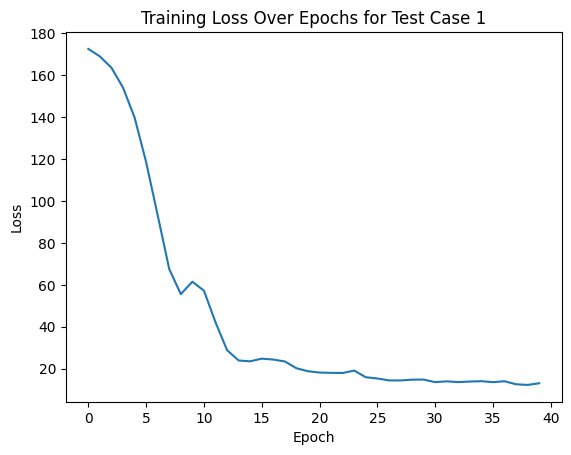

In [ ]:
import optuna

# Splitting train and validation data
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_tensor_scaled, y_train_tensor, test_size=0.2, random_state=42)

def objective(trial):
    # Define the hyperparameter search space
    n_units_1 = trial.suggest_int('n_units_1', 256, 1024)
    n_units_2 = trial.suggest_int('n_units_2', 128, 512)
    n_units_3 = trial.suggest_int('n_units_3', 64, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3)

    # Building the model with trial hyperparameters
    model = nn.Sequential(
        nn.Linear(X_train_sub.shape[1], n_units_1),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(n_units_1, n_units_2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(n_units_2, n_units_3),
        nn.ReLU(),
        nn.Linear(n_units_3, 4)  # Output layer for regression
    ).to(device)  # Move the model to the GPU

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(20):
        optimizer.zero_grad()
        outputs = model(X_train_sub).to(device)
        loss = criterion(outputs.squeeze(), y_train_sub)
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        loss.backward()
        optimizer.step()

    # Evaluate the model on validation data
    with torch.no_grad():
        val_outputs = model(X_val).to(device)
        val_outputs = torch.round(val_outputs)  # Round the predictions to the nearest integer
        val_mae = {}
        val_accuracy = {}

        for i, medal_type in enumerate(['Total', 'Gold', 'Silver', 'Bronze']):
          mae = torch.mean(torch.abs(val_outputs[:,i] - y_val[:,i])).item()
          val_mae[medal_type] = mae
          correct = torch.sum(torch.abs(val_outputs[:,i] - y_val[:,i]) <= torch.tensor(tolerance_biases[i]).to(device)*y_val[:,i])
          accuracy = correct.item() / len(y_val) * 100
          val_accuracy[medal_type] = accuracy
          val_loss = criterion(val_outputs[:,i], y_val[:,i])
        print(f"Validation Loss: {val_loss} ; Validation Accuracy: {accuracy}%")

    return sum(val_mae.values())  # Return the validation MAE as a Python numbe

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Build and evaluate the model with the best hyperparameters
n_units_1 = best_params['n_units_1']
n_units_2 = best_params['n_units_2']
n_units_3 = best_params['n_units_3']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
tolerance = 0.2
tolerance_biases = [6.0, 2.0, 2.0, 2.0]

    # Building the model with trial hyperparameters
best_model = nn.Sequential(
        nn.Linear(X_train_tensor_scaled.shape[1], n_units_1),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(n_units_1, n_units_2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(n_units_2, n_units_3),
        nn.ReLU(),
        nn.Linear(n_units_3, 4)  # Output layer for regression
    ).to(device)  # Move the model to the GPU

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate)

# Train with the entire training data and evaluate on the test set
losses = []
for epoch in range(50):
    optimizer.zero_grad()
    outputs = best_model(X_train_tensor_scaled).to(device)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    optimizer.step()

    # Evaluate the model on test data
with torch.no_grad():
    test_mae = {}
    test_accuracy = {}
    test_outputs = best_model(X_test_tensor_scaled).to(device)
    test_outputs = torch.round(test_outputs)  # Round the predictions to the nearest integer
    for i, medal_type in enumerate(['Total', 'Gold', 'Silver', 'Bronze']):
      test_loss = criterion(test_outputs[:,i], y_test_tensor[:,i])
      correct = torch.sum(torch.abs(test_outputs[:,i] - y_test_tensor[:,i]) <= torch.max(tolerance*y_test_tensor[:,i], torch.tensor(tolerance_biases[i]).to(device)))
      accuracy = correct.item() / len(y_test) * 100
      test_accuracy[medal_type] = accuracy
      mae = torch.mean(torch.abs(test_outputs[:,i] - y_test_tensor[:,i])).item()  # Calculate MAE
      test_mae[medal_type] = mae


print(f"Test MAE: {test_mae}")
print(f"Test Loss: {test_loss} ; Test Accuracy: {test_accuracy}%")
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs for Test Case 1')
plt.show()


Let's see what the results are. We already have predictions for each medal separately and total medals in the previous cell. Pretty accurate, right? Wait till you see when happens in the second test case.

In [ ]:
medal_manual_sum = torch.sum(test_outputs[:,1:], dim=1)
sum_correct = torch.sum(torch.abs(medal_manual_sum - y_test_tensor[:,0]) <= torch.max(tolerance*y_test_tensor[:,0], torch.tensor(6.0).to(device)))
sum_accuracy = sum_correct.item() / len(y_test) * 100

print(f"Test Accuracy for Manual Medal Total: {sum_accuracy}%")

Test Accuracy for Manual Medal Total: 80.51948051948052%


In [ ]:
# The Olympic medal table is ranked by and order of precedence: Gold, then Silver, then Bronze. We'll apply this precedence to our accuracy as well.
medal_importance_weight = [0.4, 0.3, 0.2, 0.1]
medal_table_accuracy_case_1 = test_accuracy['Gold']*medal_importance_weight[0] + test_accuracy['Silver']*medal_importance_weight[1] + test_accuracy['Bronze']*medal_importance_weight[2] + test_accuracy['Total']*medal_importance_weight[3]
print(f"Test Accuracy for Medal Table with Medal Precedence: {medal_table_accuracy_case_1}%")

Test Accuracy for Medal Table with Medal Precedence: 79.35064935064935%


No let's see the predicted table!

In [ ]:
test_countries = np.array(test_countries)  # Convert to a numpy array if it's not already

# Create a DataFrame from the test predictions
predictions_df = pd.DataFrame({
    'Country': test_countries,
    'Predicted Gold': test_outputs[:, 1].cpu().numpy(),
    'Predicted Silver': test_outputs[:, 2].cpu().numpy(),
    'Predicted Bronze': test_outputs[:, 3].cpu().numpy(),
    'Predicted Total': test_outputs[:, 0].cpu().numpy(),
    'Total Predicted': medal_manual_sum.cpu().numpy()
})

predictions_df = predictions_df.sort_values(by=['Predicted Gold', 'Predicted Silver', 'Predicted Bronze'], ascending=False).reset_index(drop=True)
predictions_df.index += 1
predictions_df


,Country,Predicted Gold,Predicted Silver,Predicted Bronze,Predicted Total,Total Predicted
1,USA,38.0,33.0,30.0,101.0,101.0
2,CHN,28.0,22.0,19.0,66.0,69.0
3,GER,16.0,16.0,20.0,53.0,52.0
4,AUS,14.0,14.0,16.0,44.0,44.0
5,GBR,14.0,13.0,16.0,40.0,43.0
...,...,...,...,...,...,...
73,FIN,1.0,1.0,1.0,2.0,3.0
74,QAT,1.0,1.0,1.0,2.0,3.0
75,MAR,0.0,1.0,1.0,2.0,2.0
76,ISR,0.0,0.0,1.0,1.0,1.0


And for reference, the actual table(added at the end of the Olympics):

In [ ]:
actual_df = pd.DataFrame({
    'Country': test_countries,
    'Actual Gold': y_test['Gold'].values,
    'Actual Silver': y_test['Silver'].values,
    'Actual Bronze': y_test['Bronze'].values,
    'Actual Total': y_test['Total'].values
})
actual_df = actual_df.sort_values(by=['Actual Gold', 'Actual Silver', 'Actual Bronze'], ascending=False).reset_index(drop=True)
actual_df.index += 1
actual_df

,Country,Actual Gold,Actual Silver,Actual Bronze,Actual Total
1,USA,40.0,44.0,42.0,126.0
2,CHN,40.0,27.0,24.0,91.0
3,JPN,20.0,12.0,13.0,45.0
4,AUS,18.0,19.0,16.0,53.0
5,FRA,16.0,26.0,22.0,64.0
...,...,...,...,...,...
73,TTO,0.0,0.0,0.0,0.0
74,LAT,0.0,0.0,0.0,0.0
75,BAH,0.0,0.0,0.0,0.0
76,EST,0.0,0.0,0.0,0.0


Ok, now for the second test case. Here we didn't filter anything out, just looked at all the participating countries in Paris.

[I 2024-08-24 13:27:52,932] A new study created in memory with name: no-name-3bb72962-6a47-47a8-9d3a-df1b032b5c4b
[I 2024-08-24 13:27:53,038] Trial 0 finished with value: 17.587302446365356 and parameters: {'n_units_1': 377, 'n_units_2': 137, 'n_units_3': 241, 'dropout_rate': 0.24919501985805398, 'learning_rate': 0.00036452723204178657}. Best is trial 0 with value: 17.587302446365356.
[I 2024-08-24 13:27:53,148] Trial 1 finished with value: 14.674604177474976 and parameters: {'n_units_1': 372, 'n_units_2': 137, 'n_units_3': 242, 'dropout_rate': 0.2313192976485825, 'learning_rate': 0.0008074435812107719}. Best is trial 1 with value: 14.674604177474976.


Epoch 1, Loss: 142.8269500732422
Epoch 2, Loss: 142.2433624267578
Epoch 3, Loss: 141.6947479248047
Epoch 4, Loss: 141.19638061523438
Epoch 5, Loss: 140.64739990234375
Epoch 6, Loss: 139.9910888671875
Epoch 7, Loss: 139.2223358154297
Epoch 8, Loss: 138.38807678222656
Epoch 9, Loss: 137.26275634765625
Epoch 10, Loss: 136.00534057617188
Epoch 11, Loss: 134.63832092285156
Epoch 12, Loss: 133.06175231933594
Epoch 13, Loss: 131.06240844726562
Epoch 14, Loss: 128.86868286132812
Epoch 15, Loss: 125.88297271728516
Epoch 16, Loss: 123.09815979003906
Epoch 17, Loss: 119.36692810058594
Epoch 18, Loss: 115.45862579345703
Epoch 19, Loss: 111.8175277709961
Epoch 20, Loss: 106.19941711425781
Validation Loss: 33.54762268066406 ; Validation Accuracy: 83.33333333333334%
Epoch 1, Loss: 142.3878173828125
Epoch 2, Loss: 141.17308044433594
Epoch 3, Loss: 139.93975830078125
Epoch 4, Loss: 138.1784210205078
Epoch 5, Loss: 135.75015258789062
Epoch 6, Loss: 132.59869384765625
Epoch 7, Loss: 127.9765396118164
Epo

[I 2024-08-24 13:27:53,266] Trial 2 finished with value: 13.83333444595337 and parameters: {'n_units_1': 654, 'n_units_2': 168, 'n_units_3': 166, 'dropout_rate': 0.14013928226383157, 'learning_rate': 0.0006660724068469793}. Best is trial 2 with value: 13.83333444595337.
[I 2024-08-24 13:27:53,366] Trial 3 finished with value: 17.51587414741516 and parameters: {'n_units_1': 975, 'n_units_2': 235, 'n_units_3': 159, 'dropout_rate': 0.47220950362522474, 'learning_rate': 0.0004955690819373695}. Best is trial 2 with value: 13.83333444595337.


Epoch 1, Loss: 141.866455078125
Epoch 2, Loss: 140.45425415039062
Epoch 3, Loss: 138.73086547851562
Epoch 4, Loss: 136.40542602539062
Epoch 5, Loss: 133.0830535888672
Epoch 6, Loss: 128.961181640625
Epoch 7, Loss: 123.37274169921875
Epoch 8, Loss: 116.3207015991211
Epoch 9, Loss: 108.09728240966797
Epoch 10, Loss: 98.14261627197266
Epoch 11, Loss: 85.71223449707031
Epoch 12, Loss: 74.55313110351562
Epoch 13, Loss: 62.03823471069336
Epoch 14, Loss: 51.95956039428711
Epoch 15, Loss: 45.65690994262695
Epoch 16, Loss: 43.8770637512207
Epoch 17, Loss: 44.76508331298828
Epoch 18, Loss: 45.04966354370117
Epoch 19, Loss: 40.14337921142578
Epoch 20, Loss: 34.17420959472656
Validation Loss: 12.45238208770752 ; Validation Accuracy: 74.60317460317461%
Epoch 1, Loss: 142.8075408935547
Epoch 2, Loss: 141.58984375
Epoch 3, Loss: 140.071533203125
Epoch 4, Loss: 138.20347595214844
Epoch 5, Loss: 135.70399475097656
Epoch 6, Loss: 132.13014221191406
Epoch 7, Loss: 128.7047882080078
Epoch 8, Loss: 123.407

[I 2024-08-24 13:27:53,445] Trial 4 finished with value: 17.325397729873657 and parameters: {'n_units_1': 339, 'n_units_2': 484, 'n_units_3': 150, 'dropout_rate': 0.27115771276884615, 'learning_rate': 0.0004160862137345885}. Best is trial 2 with value: 13.83333444595337.
[I 2024-08-24 13:27:53,539] Trial 5 finished with value: 11.317460894584656 and parameters: {'n_units_1': 843, 'n_units_2': 511, 'n_units_3': 202, 'dropout_rate': 0.21204368906439633, 'learning_rate': 0.0006960661780240168}. Best is trial 5 with value: 11.317460894584656.


Epoch 1, Loss: 142.31234741210938
Epoch 2, Loss: 141.4697723388672
Epoch 3, Loss: 140.62310791015625
Epoch 4, Loss: 139.51136779785156
Epoch 5, Loss: 138.19248962402344
Epoch 6, Loss: 136.5025634765625
Epoch 7, Loss: 134.49217224121094
Epoch 8, Loss: 131.99403381347656
Epoch 9, Loss: 128.9645233154297
Epoch 10, Loss: 125.06792449951172
Epoch 11, Loss: 120.07413482666016
Epoch 12, Loss: 115.24395751953125
Epoch 13, Loss: 108.84720611572266
Epoch 14, Loss: 101.46382904052734
Epoch 15, Loss: 94.58941650390625
Epoch 16, Loss: 86.47128295898438
Epoch 17, Loss: 77.63220977783203
Epoch 18, Loss: 69.43597412109375
Epoch 19, Loss: 60.961181640625
Epoch 20, Loss: 55.48771667480469
Validation Loss: 17.071430206298828 ; Validation Accuracy: 69.04761904761905%
Epoch 1, Loss: 141.65147399902344
Epoch 2, Loss: 138.498291015625
Epoch 3, Loss: 134.115234375
Epoch 4, Loss: 127.14635467529297
Epoch 5, Loss: 117.54168701171875
Epoch 6, Loss: 103.97591400146484
Epoch 7, Loss: 87.92544555664062
Epoch 8, Los

[I 2024-08-24 13:27:53,628] Trial 6 finished with value: 11.246032476425171 and parameters: {'n_units_1': 811, 'n_units_2': 504, 'n_units_3': 241, 'dropout_rate': 0.41848413331575685, 'learning_rate': 0.0007975146736891082}. Best is trial 6 with value: 11.246032476425171.
[I 2024-08-24 13:27:53,719] Trial 7 finished with value: 10.71428668498993 and parameters: {'n_units_1': 919, 'n_units_2': 389, 'n_units_3': 195, 'dropout_rate': 0.351884756421211, 'learning_rate': 0.0009622834611755437}. Best is trial 7 with value: 10.71428668498993.


Epoch 9, Loss: 54.783775329589844
Epoch 10, Loss: 52.72146987915039
Epoch 11, Loss: 53.16689682006836
Epoch 12, Loss: 44.67593002319336
Epoch 13, Loss: 33.41912841796875
Epoch 14, Loss: 27.79618263244629
Epoch 15, Loss: 24.073238372802734
Epoch 16, Loss: 23.79141616821289
Epoch 17, Loss: 22.87388801574707
Epoch 18, Loss: 22.93859100341797
Epoch 19, Loss: 18.94982147216797
Epoch 20, Loss: 18.073230743408203
Validation Loss: 11.119048118591309 ; Validation Accuracy: 87.3015873015873%
Epoch 1, Loss: 142.0308837890625
Epoch 2, Loss: 137.79896545410156
Epoch 3, Loss: 131.3867645263672
Epoch 4, Loss: 120.53582000732422
Epoch 5, Loss: 104.44387817382812
Epoch 6, Loss: 85.19315338134766
Epoch 7, Loss: 65.58695220947266
Epoch 8, Loss: 56.01390075683594
Epoch 9, Loss: 52.81453323364258
Epoch 10, Loss: 47.6982536315918
Epoch 11, Loss: 36.06142807006836
Epoch 12, Loss: 27.750717163085938
Epoch 13, Loss: 23.907535552978516
Epoch 14, Loss: 23.594867706298828
Epoch 15, Loss: 23.555139541625977
Epoch 

[I 2024-08-24 13:27:53,799] Trial 8 finished with value: 16.89682674407959 and parameters: {'n_units_1': 726, 'n_units_2': 132, 'n_units_3': 64, 'dropout_rate': 0.24701216685242489, 'learning_rate': 0.00040112098247672984}. Best is trial 7 with value: 10.71428668498993.
[I 2024-08-24 13:27:53,880] Trial 9 finished with value: 23.09523916244507 and parameters: {'n_units_1': 344, 'n_units_2': 472, 'n_units_3': 83, 'dropout_rate': 0.46487377080886316, 'learning_rate': 3.109301382066631e-05}. Best is trial 7 with value: 10.71428668498993.


Epoch 20, Loss: 93.73826599121094
Validation Loss: 32.92857360839844 ; Validation Accuracy: 84.12698412698413%
Epoch 1, Loss: 142.3582305908203
Epoch 2, Loss: 142.27130126953125
Epoch 3, Loss: 142.17666625976562
Epoch 4, Loss: 142.109130859375
Epoch 5, Loss: 142.1402587890625
Epoch 6, Loss: 142.05010986328125
Epoch 7, Loss: 141.974609375
Epoch 8, Loss: 141.8975830078125
Epoch 9, Loss: 141.8882293701172
Epoch 10, Loss: 141.8215789794922
Epoch 11, Loss: 141.7735595703125
Epoch 12, Loss: 141.74952697753906
Epoch 13, Loss: 141.6696014404297
Epoch 14, Loss: 141.62808227539062
Epoch 15, Loss: 141.5849151611328
Epoch 16, Loss: 141.52914428710938
Epoch 17, Loss: 141.4381866455078
Epoch 18, Loss: 141.41525268554688
Epoch 19, Loss: 141.37722778320312
Epoch 20, Loss: 141.29238891601562
Validation Loss: 52.111114501953125 ; Validation Accuracy: 100.0%
Epoch 1, Loss: 142.50611877441406
Epoch 2, Loss: 138.84864807128906
Epoch 3, Loss: 133.08078002929688
Epoch 4, Loss: 124.58953094482422
Epoch 5, Los

[I 2024-08-24 13:27:54,003] Trial 10 finished with value: 11.031746625900269 and parameters: {'n_units_1': 1020, 'n_units_2': 375, 'n_units_3': 115, 'dropout_rate': 0.3651226457582756, 'learning_rate': 0.0009191462510218343}. Best is trial 7 with value: 10.71428668498993.
[I 2024-08-24 13:27:54,122] Trial 11 finished with value: 11.222222685813904 and parameters: {'n_units_1': 1002, 'n_units_2': 370, 'n_units_3': 113, 'dropout_rate': 0.35869059986396207, 'learning_rate': 0.0009858377079826315}. Best is trial 7 with value: 10.71428668498993.



Validation Loss: 12.00793743133545 ; Validation Accuracy: 89.68253968253968%
Epoch 1, Loss: 143.00897216796875
Epoch 2, Loss: 140.0431365966797
Epoch 3, Loss: 135.75607299804688
Epoch 4, Loss: 128.93121337890625
Epoch 5, Loss: 119.00341033935547
Epoch 6, Loss: 105.14781951904297
Epoch 7, Loss: 88.20172119140625
Epoch 8, Loss: 72.5282211303711
Epoch 9, Loss: 57.62187957763672
Epoch 10, Loss: 52.087257385253906
Epoch 11, Loss: 49.89806365966797
Epoch 12, Loss: 44.27928924560547
Epoch 13, Loss: 33.94093322753906
Epoch 14, Loss: 27.776161193847656
Epoch 15, Loss: 22.999483108520508
Epoch 16, Loss: 22.44915008544922
Epoch 17, Loss: 21.957902908325195
Epoch 18, Loss: 21.064834594726562
Epoch 19, Loss: 20.46645164489746
Epoch 20, Loss: 20.09763526916504
Validation Loss: 16.571430206298828 ; Validation Accuracy: 91.26984126984127%
Epoch 1, Loss: 142.17933654785156
Epoch 2, Loss: 139.3053741455078
Epoch 3, Loss: 134.6440887451172
Epoch 4, Loss: 126.9090347290039
Epoch 5, Loss: 115.588104248046

[I 2024-08-24 13:27:54,236] Trial 12 finished with value: 11.031746625900269 and parameters: {'n_units_1': 894, 'n_units_2': 375, 'n_units_3': 119, 'dropout_rate': 0.34666259348374834, 'learning_rate': 0.0009735942079375324}. Best is trial 7 with value: 10.71428668498993.
[I 2024-08-24 13:27:54,367] Trial 13 finished with value: 12.261905193328857 and parameters: {'n_units_1': 529, 'n_units_2': 313, 'n_units_3': 193, 'dropout_rate': 0.3427156369199654, 'learning_rate': 0.0008379333390080497}. Best is trial 7 with value: 10.71428668498993.


Epoch 9, Loss: 53.60929870605469
Epoch 10, Loss: 49.28150939941406
Epoch 11, Loss: 44.34941864013672
Epoch 12, Loss: 36.18389129638672
Epoch 13, Loss: 28.82162857055664
Epoch 14, Loss: 25.060808181762695
Epoch 15, Loss: 24.120712280273438
Epoch 16, Loss: 23.86394500732422
Epoch 17, Loss: 24.55049705505371
Epoch 18, Loss: 22.40079116821289
Epoch 19, Loss: 20.009248733520508
Epoch 20, Loss: 17.8989200592041
Validation Loss: 8.611111640930176 ; Validation Accuracy: 81.74603174603175%
Epoch 1, Loss: 142.9404296875
Epoch 2, Loss: 140.98092651367188
Epoch 3, Loss: 138.5089111328125
Epoch 4, Loss: 134.5030517578125
Epoch 5, Loss: 129.03158569335938
Epoch 6, Loss: 120.69514465332031
Epoch 7, Loss: 109.23810577392578
Epoch 8, Loss: 96.08576965332031
Epoch 9, Loss: 79.53211212158203
Epoch 10, Loss: 63.8428955078125
Epoch 11, Loss: 53.11024856567383
Epoch 12, Loss: 48.307098388671875
Epoch 13, Loss: 47.340816497802734
Epoch 14, Loss: 44.924888610839844
Epoch 15, Loss: 39.657928466796875
Epoch 16,

[I 2024-08-24 13:27:54,478] Trial 14 finished with value: 12.333333969116211 and parameters: {'n_units_1': 928, 'n_units_2': 411, 'n_units_3': 124, 'dropout_rate': 0.3956637592784203, 'learning_rate': 0.0006320275872933289}. Best is trial 7 with value: 10.71428668498993.
[I 2024-08-24 13:27:54,589] Trial 15 finished with value: 16.753969192504883 and parameters: {'n_units_1': 1013, 'n_units_2': 296, 'n_units_3': 203, 'dropout_rate': 0.2974405472107684, 'learning_rate': 0.0002404133100658984}. Best is trial 7 with value: 10.71428668498993.


Epoch 1, Loss: 142.6722412109375
Epoch 2, Loss: 140.6742401123047
Epoch 3, Loss: 138.18374633789062
Epoch 4, Loss: 134.86618041992188
Epoch 5, Loss: 130.24935913085938
Epoch 6, Loss: 123.86091613769531
Epoch 7, Loss: 115.74742889404297
Epoch 8, Loss: 105.21810150146484
Epoch 9, Loss: 92.9700927734375
Epoch 10, Loss: 79.53217315673828
Epoch 11, Loss: 66.9151382446289
Epoch 12, Loss: 57.08088302612305
Epoch 13, Loss: 48.98598098754883
Epoch 14, Loss: 47.393009185791016
Epoch 15, Loss: 47.82524108886719
Epoch 16, Loss: 42.22592544555664
Epoch 17, Loss: 38.18911361694336
Epoch 18, Loss: 32.409881591796875
Epoch 19, Loss: 26.33672332763672
Epoch 20, Loss: 23.247623443603516
Validation Loss: 16.182540893554688 ; Validation Accuracy: 84.12698412698413%
Epoch 1, Loss: 142.45831298828125
Epoch 2, Loss: 141.6021728515625
Epoch 3, Loss: 140.8065185546875
Epoch 4, Loss: 139.9942169189453
Epoch 5, Loss: 139.05294799804688
Epoch 6, Loss: 138.05491638183594
Epoch 7, Loss: 136.93832397460938
Epoch 8, 

[I 2024-08-24 13:27:54,701] Trial 16 finished with value: 12.142858028411865 and parameters: {'n_units_1': 763, 'n_units_2': 432, 'n_units_3': 101, 'dropout_rate': 0.4175497802196301, 'learning_rate': 0.0009096487408292349}. Best is trial 7 with value: 10.71428668498993.
[I 2024-08-24 13:27:54,804] Trial 17 finished with value: 16.579366207122803 and parameters: {'n_units_1': 572, 'n_units_2': 261, 'n_units_3': 140, 'dropout_rate': 0.3154672849191302, 'learning_rate': 0.0005759013169606461}. Best is trial 7 with value: 10.71428668498993.


Epoch 1, Loss: 143.223388671875
Epoch 2, Loss: 140.84617614746094
Epoch 3, Loss: 137.7008056640625
Epoch 4, Loss: 133.1131134033203
Epoch 5, Loss: 126.24827575683594
Epoch 6, Loss: 116.45933532714844
Epoch 7, Loss: 103.39302825927734
Epoch 8, Loss: 88.09432983398438
Epoch 9, Loss: 70.7925033569336
Epoch 10, Loss: 55.14716339111328
Epoch 11, Loss: 47.24909210205078
Epoch 12, Loss: 48.0393180847168
Epoch 13, Loss: 47.838844299316406
Epoch 14, Loss: 43.68292999267578
Epoch 15, Loss: 34.991294860839844
Epoch 16, Loss: 28.72252082824707
Epoch 17, Loss: 22.376117706298828
Epoch 18, Loss: 21.64177131652832
Epoch 19, Loss: 22.437435150146484
Epoch 20, Loss: 22.003599166870117
Validation Loss: 14.222223281860352 ; Validation Accuracy: 85.71428571428571%
Epoch 1, Loss: 142.83782958984375
Epoch 2, Loss: 141.5373077392578
Epoch 3, Loss: 140.22532653808594
Epoch 4, Loss: 138.75254821777344
Epoch 5, Loss: 136.7953643798828
Epoch 6, Loss: 134.07913208007812
Epoch 7, Loss: 130.9899139404297
Epoch 8, L

[I 2024-08-24 13:27:54,921] Trial 18 finished with value: 11.904762744903564 and parameters: {'n_units_1': 887, 'n_units_2': 359, 'n_units_3': 185, 'dropout_rate': 0.11285968596656665, 'learning_rate': 0.0007482080096678991}. Best is trial 7 with value: 10.71428668498993.
[I 2024-08-24 13:27:55,043] Trial 19 finished with value: 10.904762864112854 and parameters: {'n_units_1': 732, 'n_units_2': 437, 'n_units_3': 220, 'dropout_rate': 0.3895874468454116, 'learning_rate': 0.0008827110299065938}. Best is trial 7 with value: 10.71428668498993.


Epoch 1, Loss: 142.88580322265625
Epoch 2, Loss: 140.06480407714844
Epoch 3, Loss: 136.43948364257812
Epoch 4, Loss: 131.07554626464844
Epoch 5, Loss: 123.33665466308594
Epoch 6, Loss: 112.3690414428711
Epoch 7, Loss: 98.15706634521484
Epoch 8, Loss: 82.67410278320312
Epoch 9, Loss: 66.68983459472656
Epoch 10, Loss: 53.5471076965332
Epoch 11, Loss: 48.81386947631836
Epoch 12, Loss: 49.17196273803711
Epoch 13, Loss: 45.864715576171875
Epoch 14, Loss: 37.15785217285156
Epoch 15, Loss: 29.42521095275879
Epoch 16, Loss: 24.272418975830078
Epoch 17, Loss: 22.517866134643555
Epoch 18, Loss: 21.23566436767578
Epoch 19, Loss: 22.016387939453125
Epoch 20, Loss: 20.803773880004883
Validation Loss: 13.777778625488281 ; Validation Accuracy: 87.3015873015873%
Epoch 1, Loss: 142.53414916992188
Epoch 2, Loss: 138.849609375
Epoch 3, Loss: 133.39547729492188
Epoch 4, Loss: 123.6849365234375
Epoch 5, Loss: 109.48845672607422
Epoch 6, Loss: 91.18360900878906
Epoch 7, Loss: 69.80435943603516
Epoch 8, Loss

[I 2024-08-24 13:27:55,154] Trial 20 finished with value: 20.15873146057129 and parameters: {'n_units_1': 691, 'n_units_2': 438, 'n_units_3': 215, 'dropout_rate': 0.49270350932998996, 'learning_rate': 0.0001382605514372042}. Best is trial 7 with value: 10.71428668498993.
[I 2024-08-24 13:27:55,271] Trial 21 finished with value: 11.111111640930176 and parameters: {'n_units_1': 796, 'n_units_2': 413, 'n_units_3': 221, 'dropout_rate': 0.3846122172240525, 'learning_rate': 0.0008756883944831843}. Best is trial 7 with value: 10.71428668498993.


Epoch 1, Loss: 143.1056671142578
Epoch 2, Loss: 142.70028686523438
Epoch 3, Loss: 142.13339233398438
Epoch 4, Loss: 141.66798400878906
Epoch 5, Loss: 141.2566375732422
Epoch 6, Loss: 140.64610290527344
Epoch 7, Loss: 140.0916748046875
Epoch 8, Loss: 139.52474975585938
Epoch 9, Loss: 138.66824340820312
Epoch 10, Loss: 138.11376953125
Epoch 11, Loss: 137.4492950439453
Epoch 12, Loss: 136.2523651123047
Epoch 13, Loss: 135.503173828125
Epoch 14, Loss: 134.1257781982422
Epoch 15, Loss: 133.28623962402344
Epoch 16, Loss: 131.8738555908203
Epoch 17, Loss: 130.20306396484375
Epoch 18, Loss: 128.87474060058594
Epoch 19, Loss: 126.99617767333984
Epoch 20, Loss: 125.05786895751953
Validation Loss: 48.88095474243164 ; Validation Accuracy: 99.20634920634922%
Epoch 1, Loss: 142.26596069335938
Epoch 2, Loss: 139.2106170654297
Epoch 3, Loss: 134.5677490234375
Epoch 4, Loss: 127.34358978271484
Epoch 5, Loss: 116.40090942382812
Epoch 6, Loss: 100.70023345947266
Epoch 7, Loss: 83.12626647949219
Epoch 8, 

[I 2024-08-24 13:27:55,401] Trial 22 finished with value: 11.293651223182678 and parameters: {'n_units_1': 946, 'n_units_2': 343, 'n_units_3': 175, 'dropout_rate': 0.4108601082766337, 'learning_rate': 0.0009184803483067676}. Best is trial 7 with value: 10.71428668498993.
[I 2024-08-24 13:27:55,512] Trial 23 finished with value: 10.531746625900269 and parameters: {'n_units_1': 573, 'n_units_2': 390, 'n_units_3': 223, 'dropout_rate': 0.44475484609417093, 'learning_rate': 0.0009873898517750363}. Best is trial 23 with value: 10.531746625900269.


Epoch 1, Loss: 142.47125244140625
Epoch 2, Loss: 139.42636108398438
Epoch 3, Loss: 134.7915496826172
Epoch 4, Loss: 127.21322631835938
Epoch 5, Loss: 115.75272369384766
Epoch 6, Loss: 100.69065856933594
Epoch 7, Loss: 81.66985321044922
Epoch 8, Loss: 63.99440002441406
Epoch 9, Loss: 53.19666290283203
Epoch 10, Loss: 50.574127197265625
Epoch 11, Loss: 48.14765930175781
Epoch 12, Loss: 40.39424133300781
Epoch 13, Loss: 31.224618911743164
Epoch 14, Loss: 25.236862182617188
Epoch 15, Loss: 24.226707458496094
Epoch 16, Loss: 23.34971809387207
Epoch 17, Loss: 24.489099502563477
Epoch 18, Loss: 23.013906478881836
Epoch 19, Loss: 19.693096160888672
Epoch 20, Loss: 16.99041175842285
Validation Loss: 12.00793743133545 ; Validation Accuracy: 86.5079365079365%
Epoch 1, Loss: 141.9036102294922
Epoch 2, Loss: 138.22103881835938
Epoch 3, Loss: 132.3835906982422
Epoch 4, Loss: 122.88277435302734
Epoch 5, Loss: 108.94891357421875
Epoch 6, Loss: 89.24407196044922
Epoch 7, Loss: 70.06372833251953
Epoch 8

[I 2024-08-24 13:27:55,624] Trial 24 finished with value: 11.214286088943481 and parameters: {'n_units_1': 496, 'n_units_2': 446, 'n_units_3': 219, 'dropout_rate': 0.4506961819983549, 'learning_rate': 0.0009942705280950944}. Best is trial 23 with value: 10.531746625900269.
[I 2024-08-24 13:27:55,734] Trial 25 finished with value: 12.246032476425171 and parameters: {'n_units_1': 589, 'n_units_2': 404, 'n_units_3': 254, 'dropout_rate': 0.4488219010811397, 'learning_rate': 0.0007497622176930459}. Best is trial 23 with value: 10.531746625900269.


Epoch 1, Loss: 142.34400939941406
Epoch 2, Loss: 139.5225067138672
Epoch 3, Loss: 135.093505859375
Epoch 4, Loss: 128.65301513671875
Epoch 5, Loss: 117.61744689941406
Epoch 6, Loss: 102.56558227539062
Epoch 7, Loss: 84.21908569335938
Epoch 8, Loss: 65.99674987792969
Epoch 9, Loss: 55.09259796142578
Epoch 10, Loss: 51.41516876220703
Epoch 11, Loss: 50.067832946777344
Epoch 12, Loss: 42.09786605834961
Epoch 13, Loss: 31.51522445678711
Epoch 14, Loss: 25.140281677246094
Epoch 15, Loss: 23.134689331054688
Epoch 16, Loss: 22.647647857666016
Epoch 17, Loss: 24.880544662475586
Epoch 18, Loss: 24.327238082885742
Epoch 19, Loss: 20.97006607055664
Epoch 20, Loss: 17.729990005493164
Validation Loss: 10.94444465637207 ; Validation Accuracy: 84.92063492063492%
Epoch 1, Loss: 142.2076416015625
Epoch 2, Loss: 139.6584014892578
Epoch 3, Loss: 136.14830017089844
Epoch 4, Loss: 130.81077575683594
Epoch 5, Loss: 122.45797729492188
Epoch 6, Loss: 111.91250610351562
Epoch 7, Loss: 97.36781311035156
Epoch 8

[I 2024-08-24 13:27:55,850] Trial 26 finished with value: 11.738096117973328 and parameters: {'n_units_1': 446, 'n_units_2': 459, 'n_units_3': 228, 'dropout_rate': 0.31540036056148396, 'learning_rate': 0.0008499194442125965}. Best is trial 23 with value: 10.531746625900269.
[I 2024-08-24 13:27:55,963] Trial 27 finished with value: 12.198413372039795 and parameters: {'n_units_1': 629, 'n_units_2': 396, 'n_units_3': 206, 'dropout_rate': 0.4334579228837898, 'learning_rate': 0.0007480304443850124}. Best is trial 23 with value: 10.531746625900269.


Epoch 1, Loss: 142.23291015625
Epoch 2, Loss: 139.28543090820312
Epoch 3, Loss: 135.03070068359375
Epoch 4, Loss: 128.9043731689453
Epoch 5, Loss: 118.99472045898438
Epoch 6, Loss: 106.30177307128906
Epoch 7, Loss: 90.11805725097656
Epoch 8, Loss: 72.70201873779297
Epoch 9, Loss: 57.637428283691406
Epoch 10, Loss: 50.051910400390625
Epoch 11, Loss: 51.05404281616211
Epoch 12, Loss: 47.39744567871094
Epoch 13, Loss: 40.33777618408203
Epoch 14, Loss: 30.892906188964844
Epoch 15, Loss: 25.29702377319336
Epoch 16, Loss: 22.96903419494629
Epoch 17, Loss: 22.35023307800293
Epoch 18, Loss: 23.53437042236328
Epoch 19, Loss: 21.644136428833008
Epoch 20, Loss: 20.280864715576172
Validation Loss: 12.960318565368652 ; Validation Accuracy: 85.71428571428571%
Epoch 1, Loss: 142.5230712890625
Epoch 2, Loss: 140.23326110839844
Epoch 3, Loss: 137.18482971191406
Epoch 4, Loss: 132.69989013671875
Epoch 5, Loss: 125.91027069091797
Epoch 6, Loss: 116.84403228759766
Epoch 7, Loss: 106.03590393066406
Epoch 8

[I 2024-08-24 13:27:56,089] Trial 28 finished with value: 13.436508655548096 and parameters: {'n_units_1': 718, 'n_units_2': 332, 'n_units_3': 189, 'dropout_rate': 0.37260599136231287, 'learning_rate': 0.0005597948658971839}. Best is trial 23 with value: 10.531746625900269.
[I 2024-08-24 13:27:56,209] Trial 29 finished with value: 12.634921073913574 and parameters: {'n_units_1': 282, 'n_units_2': 285, 'n_units_3': 235, 'dropout_rate': 0.49082296349667964, 'learning_rate': 0.0009104510478054083}. Best is trial 23 with value: 10.531746625900269.


Epoch 1, Loss: 141.80052185058594
Epoch 2, Loss: 139.90184020996094
Epoch 3, Loss: 137.70697021484375
Epoch 4, Loss: 134.52484130859375
Epoch 5, Loss: 130.35940551757812
Epoch 6, Loss: 124.97958374023438
Epoch 7, Loss: 117.38278198242188
Epoch 8, Loss: 109.3415756225586
Epoch 9, Loss: 97.42581176757812
Epoch 10, Loss: 87.1673583984375
Epoch 11, Loss: 73.74508666992188
Epoch 12, Loss: 64.39180755615234
Epoch 13, Loss: 52.70424270629883
Epoch 14, Loss: 48.9541130065918
Epoch 15, Loss: 47.35409927368164
Epoch 16, Loss: 45.879825592041016
Epoch 17, Loss: 42.76941680908203
Epoch 18, Loss: 36.724525451660156
Epoch 19, Loss: 31.282079696655273
Epoch 20, Loss: 26.74263572692871
Validation Loss: 13.015873908996582 ; Validation Accuracy: 77.77777777777779%
Epoch 1, Loss: 143.09176635742188
Epoch 2, Loss: 141.35211181640625
Epoch 3, Loss: 139.1102294921875
Epoch 4, Loss: 135.7685089111328
Epoch 5, Loss: 131.6435546875
Epoch 6, Loss: 125.61383056640625
Epoch 7, Loss: 117.91719055175781
Epoch 8, Lo

[I 2024-08-24 13:27:56,326] Trial 30 finished with value: 11.523810386657715 and parameters: {'n_units_1': 477, 'n_units_2': 421, 'n_units_3': 180, 'dropout_rate': 0.39288637367550366, 'learning_rate': 0.00098637716412177}. Best is trial 23 with value: 10.531746625900269.
[I 2024-08-24 13:27:56,462] Trial 31 finished with value: 10.412698984146118 and parameters: {'n_units_1': 889, 'n_units_2': 384, 'n_units_3': 250, 'dropout_rate': 0.33222245538600265, 'learning_rate': 0.0009220597685797798}. Best is trial 31 with value: 10.412698984146118.


Epoch 1, Loss: 142.36862182617188
Epoch 2, Loss: 139.5894012451172
Epoch 3, Loss: 135.47488403320312
Epoch 4, Loss: 128.78842163085938
Epoch 5, Loss: 118.88807678222656
Epoch 6, Loss: 105.81011199951172
Epoch 7, Loss: 88.82828521728516
Epoch 8, Loss: 73.07609558105469
Epoch 9, Loss: 58.33993148803711
Epoch 10, Loss: 52.8261604309082
Epoch 11, Loss: 50.44083023071289
Epoch 12, Loss: 43.082618713378906
Epoch 13, Loss: 32.719932556152344
Epoch 14, Loss: 27.489025115966797
Epoch 15, Loss: 24.356651306152344
Epoch 16, Loss: 23.265687942504883
Epoch 17, Loss: 23.620159149169922
Epoch 18, Loss: 22.93297576904297
Epoch 19, Loss: 21.613622665405273
Epoch 20, Loss: 21.725662231445312
Validation Loss: 16.365079879760742 ; Validation Accuracy: 89.68253968253968%
Epoch 1, Loss: 142.31256103515625
Epoch 2, Loss: 138.6081085205078
Epoch 3, Loss: 132.68324279785156
Epoch 4, Loss: 122.76116180419922
Epoch 5, Loss: 108.20539855957031
Epoch 6, Loss: 88.20560455322266
Epoch 7, Loss: 69.2176742553711
Epoch

[I 2024-08-24 13:27:56,588] Trial 32 finished with value: 10.857143521308899 and parameters: {'n_units_1': 858, 'n_units_2': 388, 'n_units_3': 255, 'dropout_rate': 0.32610306936747413, 'learning_rate': 0.0007906587402977101}. Best is trial 31 with value: 10.412698984146118.
[I 2024-08-24 13:27:56,708] Trial 33 finished with value: 10.936508655548096 and parameters: {'n_units_1': 858, 'n_units_2': 387, 'n_units_3': 251, 'dropout_rate': 0.20240219641977691, 'learning_rate': 0.000801084474230477}. Best is trial 31 with value: 10.412698984146118.


Epoch 1, Loss: 142.76248168945312
Epoch 2, Loss: 139.9091033935547
Epoch 3, Loss: 135.64028930664062
Epoch 4, Loss: 128.65582275390625
Epoch 5, Loss: 118.66780090332031
Epoch 6, Loss: 104.1659927368164
Epoch 7, Loss: 86.37110900878906
Epoch 8, Loss: 68.87474060058594
Epoch 9, Loss: 55.96403503417969
Epoch 10, Loss: 53.0850830078125
Epoch 11, Loss: 51.18939971923828
Epoch 12, Loss: 44.347354888916016
Epoch 13, Loss: 35.14632034301758
Epoch 14, Loss: 27.715744018554688
Epoch 15, Loss: 24.2402286529541
Epoch 16, Loss: 23.977598190307617
Epoch 17, Loss: 23.4105281829834
Epoch 18, Loss: 21.682941436767578
Epoch 19, Loss: 20.62409019470215
Epoch 20, Loss: 19.018104553222656
Validation Loss: 11.380952835083008 ; Validation Accuracy: 85.71428571428571%
Epoch 1, Loss: 142.2078857421875
Epoch 2, Loss: 138.69671630859375
Epoch 3, Loss: 133.32186889648438
Epoch 4, Loss: 124.89276123046875
Epoch 5, Loss: 113.05017852783203
Epoch 6, Loss: 97.42588806152344
Epoch 7, Loss: 77.69721984863281
Epoch 8, L

[I 2024-08-24 13:27:56,838] Trial 34 finished with value: 10.45238184928894 and parameters: {'n_units_1': 934, 'n_units_2': 347, 'n_units_3': 255, 'dropout_rate': 0.28931845839384607, 'learning_rate': 0.0009461951248958981}. Best is trial 31 with value: 10.412698984146118.
[I 2024-08-24 13:27:56,957] Trial 35 finished with value: 10.380952954292297 and parameters: {'n_units_1': 943, 'n_units_2': 351, 'n_units_3': 234, 'dropout_rate': 0.2859368323997199, 'learning_rate': 0.0009376647360123405}. Best is trial 35 with value: 10.380952954292297.


Epoch 1, Loss: 142.12368774414062
Epoch 2, Loss: 138.30067443847656
Epoch 3, Loss: 132.16244506835938
Epoch 4, Loss: 121.760009765625
Epoch 5, Loss: 106.23316192626953
Epoch 6, Loss: 86.15620422363281
Epoch 7, Loss: 64.80757904052734
Epoch 8, Loss: 51.25374984741211
Epoch 9, Loss: 53.98984909057617
Epoch 10, Loss: 49.36248779296875
Epoch 11, Loss: 37.25786209106445
Epoch 12, Loss: 27.815040588378906
Epoch 13, Loss: 23.46375846862793
Epoch 14, Loss: 21.594337463378906
Epoch 15, Loss: 23.13289451599121
Epoch 16, Loss: 22.17896842956543
Epoch 17, Loss: 20.232257843017578
Epoch 18, Loss: 17.11330795288086
Epoch 19, Loss: 16.91273307800293
Epoch 20, Loss: 17.281824111938477
Validation Loss: 8.928571701049805 ; Validation Accuracy: 85.71428571428571%
Epoch 1, Loss: 142.1660614013672
Epoch 2, Loss: 138.68740844726562
Epoch 3, Loss: 132.7515106201172
Epoch 4, Loss: 122.97481536865234
Epoch 5, Loss: 108.37969207763672
Epoch 6, Loss: 88.9034194946289
Epoch 7, Loss: 69.38694763183594
Epoch 8, Los

[I 2024-08-24 13:27:57,083] Trial 36 finished with value: 11.904762744903564 and parameters: {'n_units_1': 970, 'n_units_2': 219, 'n_units_3': 237, 'dropout_rate': 0.2815890421321342, 'learning_rate': 0.0007103223083193996}. Best is trial 35 with value: 10.380952954292297.
[I 2024-08-24 13:27:57,198] Trial 37 finished with value: 11.730159282684326 and parameters: {'n_units_1': 409, 'n_units_2': 349, 'n_units_3': 248, 'dropout_rate': 0.179024710475474, 'learning_rate': 0.0009380902860923164}. Best is trial 35 with value: 10.380952954292297.


Epoch 1, Loss: 142.3513946533203
Epoch 2, Loss: 139.94387817382812
Epoch 3, Loss: 136.70809936523438
Epoch 4, Loss: 132.3212127685547
Epoch 5, Loss: 125.68909454345703
Epoch 6, Loss: 116.82474517822266
Epoch 7, Loss: 105.94878387451172
Epoch 8, Loss: 91.5390625
Epoch 9, Loss: 77.06800842285156
Epoch 10, Loss: 62.75016784667969
Epoch 11, Loss: 50.823551177978516
Epoch 12, Loss: 48.84688949584961
Epoch 13, Loss: 46.87797164916992
Epoch 14, Loss: 46.732181549072266
Epoch 15, Loss: 41.67831802368164
Epoch 16, Loss: 33.446495056152344
Epoch 17, Loss: 26.524524688720703
Epoch 18, Loss: 23.482206344604492
Epoch 19, Loss: 22.333911895751953
Epoch 20, Loss: 22.718442916870117
Validation Loss: 16.753969192504883 ; Validation Accuracy: 86.5079365079365%
Epoch 1, Loss: 142.6103057861328
Epoch 2, Loss: 140.72491455078125
Epoch 3, Loss: 138.22833251953125
Epoch 4, Loss: 134.49966430664062
Epoch 5, Loss: 128.5006866455078
Epoch 6, Loss: 120.00755310058594
Epoch 7, Loss: 108.11259460449219
Epoch 8, Lo

[I 2024-08-24 13:27:57,319] Trial 38 finished with value: 12.087302207946777 and parameters: {'n_units_1': 645, 'n_units_2': 318, 'n_units_3': 235, 'dropout_rate': 0.26600998134441955, 'learning_rate': 0.0008385078103047194}. Best is trial 35 with value: 10.380952954292297.
[I 2024-08-24 13:27:57,450] Trial 39 finished with value: 15.6269850730896 and parameters: {'n_units_1': 806, 'n_units_2': 275, 'n_units_3': 243, 'dropout_rate': 0.2375943285449915, 'learning_rate': 0.0002736408079262424}. Best is trial 35 with value: 10.380952954292297.


Epoch 1, Loss: 142.6892852783203
Epoch 2, Loss: 140.3510284423828
Epoch 3, Loss: 137.44143676757812
Epoch 4, Loss: 133.11990356445312
Epoch 5, Loss: 126.16498565673828
Epoch 6, Loss: 117.32667541503906
Epoch 7, Loss: 104.13611602783203
Epoch 8, Loss: 88.7960205078125
Epoch 9, Loss: 72.24471282958984
Epoch 10, Loss: 57.41191482543945
Epoch 11, Loss: 50.81568145751953
Epoch 12, Loss: 48.52290344238281
Epoch 13, Loss: 48.28535079956055
Epoch 14, Loss: 40.80984115600586
Epoch 15, Loss: 32.14240646362305
Epoch 16, Loss: 25.34177017211914
Epoch 17, Loss: 23.210817337036133
Epoch 18, Loss: 22.040639877319336
Epoch 19, Loss: 22.350072860717773
Epoch 20, Loss: 21.849388122558594
Validation Loss: 16.15873146057129 ; Validation Accuracy: 88.09523809523809%
Epoch 1, Loss: 142.7874298095703
Epoch 2, Loss: 141.9644012451172
Epoch 3, Loss: 141.15887451171875
Epoch 4, Loss: 140.24996948242188
Epoch 5, Loss: 139.12200927734375
Epoch 6, Loss: 137.98167419433594
Epoch 7, Loss: 136.47494506835938
Epoch 8,

[I 2024-08-24 13:27:57,573] Trial 40 finished with value: 12.015873908996582 and parameters: {'n_units_1': 966, 'n_units_2': 235, 'n_units_3': 231, 'dropout_rate': 0.21270242833705616, 'learning_rate': 0.0006438998664753458}. Best is trial 35 with value: 10.380952954292297.
[I 2024-08-24 13:27:57,690] Trial 41 finished with value: 10.666667342185974 and parameters: {'n_units_1': 913, 'n_units_2': 334, 'n_units_3': 211, 'dropout_rate': 0.2922714343034304, 'learning_rate': 0.0009590795738730137}. Best is trial 35 with value: 10.380952954292297.


Epoch 1, Loss: 142.2861785888672
Epoch 2, Loss: 140.4331512451172
Epoch 3, Loss: 138.10324096679688
Epoch 4, Loss: 134.81272888183594
Epoch 5, Loss: 130.05796813964844
Epoch 6, Loss: 123.96952819824219
Epoch 7, Loss: 115.74911499023438
Epoch 8, Loss: 104.69091033935547
Epoch 9, Loss: 92.86273956298828
Epoch 10, Loss: 79.24016571044922
Epoch 11, Loss: 65.88111877441406
Epoch 12, Loss: 54.56180953979492
Epoch 13, Loss: 48.061405181884766
Epoch 14, Loss: 48.972328186035156
Epoch 15, Loss: 46.86617660522461
Epoch 16, Loss: 42.91321563720703
Epoch 17, Loss: 37.012699127197266
Epoch 18, Loss: 30.106342315673828
Epoch 19, Loss: 25.399259567260742
Epoch 20, Loss: 22.698196411132812
Validation Loss: 12.158730506896973 ; Validation Accuracy: 78.57142857142857%
Epoch 1, Loss: 142.0428009033203
Epoch 2, Loss: 138.51046752929688
Epoch 3, Loss: 132.63673400878906
Epoch 4, Loss: 122.85050201416016
Epoch 5, Loss: 108.38225555419922
Epoch 6, Loss: 89.90153503417969
Epoch 7, Loss: 69.35699462890625
Epoc

[I 2024-08-24 13:27:57,813] Trial 42 finished with value: 10.801587700843811 and parameters: {'n_units_1': 910, 'n_units_2': 335, 'n_units_3': 210, 'dropout_rate': 0.2992694082484137, 'learning_rate': 0.0009437540676396386}. Best is trial 35 with value: 10.380952954292297.
[I 2024-08-24 13:27:57,929] Trial 43 finished with value: 10.928572297096252 and parameters: {'n_units_1': 853, 'n_units_2': 304, 'n_units_3': 227, 'dropout_rate': 0.2610943558183828, 'learning_rate': 0.0008815061115694667}. Best is trial 35 with value: 10.380952954292297.


Epoch 1, Loss: 142.15879821777344
Epoch 2, Loss: 138.8486785888672
Epoch 3, Loss: 133.691650390625
Epoch 4, Loss: 125.14075469970703
Epoch 5, Loss: 112.59876251220703
Epoch 6, Loss: 95.3432388305664
Epoch 7, Loss: 75.14813995361328
Epoch 8, Loss: 58.943321228027344
Epoch 9, Loss: 51.31354522705078
Epoch 10, Loss: 52.500709533691406
Epoch 11, Loss: 45.59122085571289
Epoch 12, Loss: 35.64773178100586
Epoch 13, Loss: 26.956056594848633
Epoch 14, Loss: 23.62547492980957
Epoch 15, Loss: 22.318485260009766
Epoch 16, Loss: 23.964303970336914
Epoch 17, Loss: 23.43780517578125
Epoch 18, Loss: 21.42290687561035
Epoch 19, Loss: 18.33456802368164
Epoch 20, Loss: 17.20513343811035
Validation Loss: 10.642857551574707 ; Validation Accuracy: 85.71428571428571%
Epoch 1, Loss: 142.1949462890625
Epoch 2, Loss: 139.20114135742188
Epoch 3, Loss: 134.52761840820312
Epoch 4, Loss: 126.68972778320312
Epoch 5, Loss: 115.49188232421875
Epoch 6, Loss: 99.93568420410156
Epoch 7, Loss: 81.96344757080078
Epoch 8, L

[I 2024-08-24 13:27:58,066] Trial 44 finished with value: 10.50793707370758 and parameters: {'n_units_1': 969, 'n_units_2': 360, 'n_units_3': 243, 'dropout_rate': 0.29288839913580644, 'learning_rate': 0.0009565168812117623}. Best is trial 35 with value: 10.380952954292297.
[I 2024-08-24 13:27:58,192] Trial 45 finished with value: 10.690476655960083 and parameters: {'n_units_1': 986, 'n_units_2': 361, 'n_units_3': 243, 'dropout_rate': 0.2533799496197663, 'learning_rate': 0.0008335242884434171}. Best is trial 35 with value: 10.380952954292297.


Epoch 1, Loss: 142.2255401611328
Epoch 2, Loss: 137.85302734375
Epoch 3, Loss: 130.87413024902344
Epoch 4, Loss: 119.09879302978516
Epoch 5, Loss: 101.88177490234375
Epoch 6, Loss: 81.23932647705078
Epoch 7, Loss: 62.88689041137695
Epoch 8, Loss: 54.47187042236328
Epoch 9, Loss: 52.889068603515625
Epoch 10, Loss: 45.71772384643555
Epoch 11, Loss: 32.6693229675293
Epoch 12, Loss: 25.934146881103516
Epoch 13, Loss: 23.15921974182129
Epoch 14, Loss: 22.906055450439453
Epoch 15, Loss: 21.94520378112793
Epoch 16, Loss: 21.423128128051758
Epoch 17, Loss: 18.497045516967773
Epoch 18, Loss: 17.05173110961914
Epoch 19, Loss: 15.55190372467041
Epoch 20, Loss: 17.36486053466797
Validation Loss: 9.833333969116211 ; Validation Accuracy: 84.12698412698413%
Epoch 1, Loss: 142.12359619140625
Epoch 2, Loss: 139.0504913330078
Epoch 3, Loss: 134.1995086669922
Epoch 4, Loss: 126.75885009765625
Epoch 5, Loss: 114.86052703857422
Epoch 6, Loss: 99.42046356201172
Epoch 7, Loss: 80.19286346435547
Epoch 8, Loss

[I 2024-08-24 13:27:58,323] Trial 46 finished with value: 10.261905550956726 and parameters: {'n_units_1': 961, 'n_units_2': 361, 'n_units_3': 256, 'dropout_rate': 0.3235705115906761, 'learning_rate': 0.000996028437089951}. Best is trial 46 with value: 10.261905550956726.
[I 2024-08-24 13:27:58,452] Trial 47 finished with value: 10.833333969116211 and parameters: {'n_units_1': 950, 'n_units_2': 358, 'n_units_3': 256, 'dropout_rate': 0.32396696405240893, 'learning_rate': 0.0008846433553868713}. Best is trial 46 with value: 10.261905550956726.


Epoch 1, Loss: 142.41799926757812
Epoch 2, Loss: 138.92530822753906
Epoch 3, Loss: 133.28292846679688
Epoch 4, Loss: 123.1352767944336
Epoch 5, Loss: 108.57364654541016
Epoch 6, Loss: 87.86333465576172
Epoch 7, Loss: 66.70677185058594
Epoch 8, Loss: 51.112884521484375
Epoch 9, Loss: 53.096466064453125
Epoch 10, Loss: 48.9223747253418
Epoch 11, Loss: 38.124908447265625
Epoch 12, Loss: 26.620820999145508
Epoch 13, Loss: 22.90922737121582
Epoch 14, Loss: 24.366830825805664
Epoch 15, Loss: 23.748905181884766
Epoch 16, Loss: 22.28428840637207
Epoch 17, Loss: 20.074954986572266
Epoch 18, Loss: 18.23473358154297
Epoch 19, Loss: 16.34359359741211
Epoch 20, Loss: 16.266983032226562
Validation Loss: 9.80158805847168 ; Validation Accuracy: 88.09523809523809%
Epoch 1, Loss: 142.5895538330078
Epoch 2, Loss: 139.41754150390625
Epoch 3, Loss: 134.4119873046875
Epoch 4, Loss: 126.33203125
Epoch 5, Loss: 114.04458618164062
Epoch 6, Loss: 97.2333984375
Epoch 7, Loss: 77.7706069946289
Epoch 8, Loss: 59.9

[I 2024-08-24 13:27:58,578] Trial 48 finished with value: 12.246032476425171 and parameters: {'n_units_1': 1022, 'n_units_2': 160, 'n_units_3': 246, 'dropout_rate': 0.2798062955504762, 'learning_rate': 0.0007822106298726332}. Best is trial 46 with value: 10.261905550956726.
[I 2024-08-24 13:27:58,696] Trial 49 finished with value: 13.12698483467102 and parameters: {'n_units_1': 883, 'n_units_2': 370, 'n_units_3': 239, 'dropout_rate': 0.3403176949794923, 'learning_rate': 0.00047359086613964175}. Best is trial 46 with value: 10.261905550956726.


Epoch 1, Loss: 142.22003173828125
Epoch 2, Loss: 139.71353149414062
Epoch 3, Loss: 136.22152709960938
Epoch 4, Loss: 131.11569213867188
Epoch 5, Loss: 124.26997375488281
Epoch 6, Loss: 115.04926300048828
Epoch 7, Loss: 102.5705795288086
Epoch 8, Loss: 88.6513442993164
Epoch 9, Loss: 73.3294906616211
Epoch 10, Loss: 59.04043197631836
Epoch 11, Loss: 50.836952209472656
Epoch 12, Loss: 47.38157653808594
Epoch 13, Loss: 46.839664459228516
Epoch 14, Loss: 42.98970031738281
Epoch 15, Loss: 35.82948684692383
Epoch 16, Loss: 28.78919219970703
Epoch 17, Loss: 24.618507385253906
Epoch 18, Loss: 22.683252334594727
Epoch 19, Loss: 21.371183395385742
Epoch 20, Loss: 22.668420791625977
Validation Loss: 17.285715103149414 ; Validation Accuracy: 87.3015873015873%
Epoch 1, Loss: 142.1805419921875
Epoch 2, Loss: 140.4493865966797
Epoch 3, Loss: 138.16989135742188
Epoch 4, Loss: 135.02291870117188
Epoch 5, Loss: 130.948486328125
Epoch 6, Loss: 125.46658325195312
Epoch 7, Loss: 118.1597900390625
Epoch 8, 

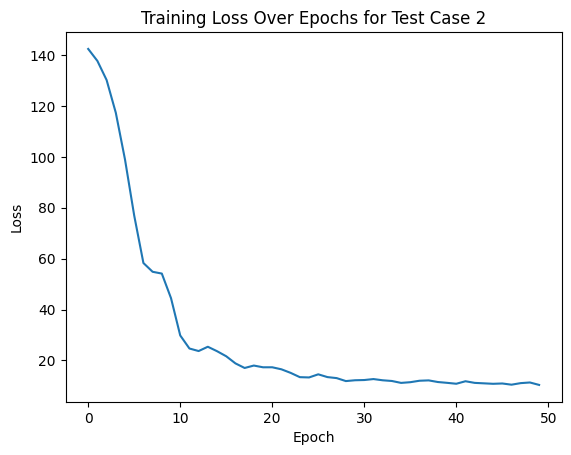

In [ ]:
# Test case 2:

# Splitting train and validation data
X_train_sub_2, X_val_2, y_train_sub_2, y_val_2 = train_test_split(X_train_tensor_scaled_2, y_train_tensor_2, test_size=0.2, random_state=42)

def objective(trial):
    # Define the hyperparameter search space
    n_units_1 = trial.suggest_int('n_units_1', 256, 1024)
    n_units_2 = trial.suggest_int('n_units_2', 128, 512)
    n_units_3 = trial.suggest_int('n_units_3', 64, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3)

    # Building the model with trial hyperparameters
    model = nn.Sequential(
        nn.Linear(X_train_sub.shape[1], n_units_1),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(n_units_1, n_units_2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(n_units_2, n_units_3),
        nn.ReLU(),
        nn.Linear(n_units_3, 4)  # Output layer for regression
    ).to(device)  # Move the model to the GPU

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(20):
        optimizer.zero_grad()
        outputs = model(X_train_sub_2).to(device)
        loss = criterion(outputs.squeeze(), y_train_sub_2)
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        loss.backward()
        optimizer.step()

    # Evaluate the model on validation data
    with torch.no_grad():
        val_outputs = model(X_val_2).to(device)
        val_outputs = torch.round(val_outputs)  # Round the predictions to the nearest integer
        val_mae = {}
        val_accuracy = {}
        tolerance = 0.2
        tolerance_biases = [6.0, 2.0, 2.0, 2.0]
        for i, medal_type in enumerate(['Total', 'Gold', 'Silver', 'Bronze']):
          mae = torch.mean(torch.abs(val_outputs[:,i] - y_val_2[:,i])).item()
          val_mae[medal_type] = mae
          correct = torch.sum(torch.abs(val_outputs[:,i] - y_val_2[:,i]) <= torch.tensor(tolerance_biases[i]).to(device)*y_val_2[:,i])
          accuracy = correct.item() / len(y_val_2) * 100
          val_accuracy[medal_type] = accuracy
          val_loss = criterion(val_outputs[:,i], y_val_2[:,i])
        print(f"Validation Loss: {val_loss} ; Validation Accuracy: {accuracy}%")

    return sum(val_mae.values())  # Return the validation MAE as a Python numbe

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Build and evaluate the model with the best hyperparameters
n_units_1 = best_params['n_units_1']
n_units_2 = best_params['n_units_2']
n_units_3 = best_params['n_units_3']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
tolerance = 0.2
tolerance_biases = [6.0, 2.0, 2.0, 2.0]

    # Building the model with trial hyperparameters
best_model = nn.Sequential(
        nn.Linear(X_train_tensor_scaled_2.shape[1], n_units_1),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(n_units_1, n_units_2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(n_units_2, n_units_3),
        nn.ReLU(),
        nn.Linear(n_units_3, 4)  # Output layer for regression
    ).to(device)  # Move the model to the GPU

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate)

# Train with the entire training data and evaluate on the test set
losses = []
for epoch in range(50):
    optimizer.zero_grad()
    outputs = best_model(X_train_tensor_scaled_2).to(device)
    loss = criterion(outputs.squeeze(), y_train_tensor_2)
    loss.backward()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    optimizer.step()

    # Evaluate the model on test data
with torch.no_grad():
    test_mae = {}
    test_accuracy_2 = {}
    test_outputs_2 = best_model(X_test_tensor_scaled_2).to(device)
    test_outputs_2 = torch.round(test_outputs_2)  # Round the predictions to the nearest integer
    for i, medal_type in enumerate(['Total', 'Gold', 'Silver', 'Bronze']):
      test_loss = criterion(test_outputs_2[:,i], y_test_tensor_2[:,i])
      correct = torch.sum(torch.abs(test_outputs_2[:,i] - y_test_tensor_2[:,i]) <= torch.max(tolerance*y_test_tensor_2[:,i], torch.tensor(tolerance_biases[i]).to(device)))
      accuracy = correct.item() / len(y_test_2) * 100
      test_accuracy_2[medal_type] = accuracy
      mae = torch.mean(torch.abs(test_outputs_2[:,i] - y_test_tensor_2[:,i])).item()  # Calculate MAE
      test_mae[medal_type] = mae


print(f"Test MAE: {test_mae}")
print(f"Test Loss: {test_loss} ; Test Accuracy: {test_accuracy_2}%")
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs for Test Case 2')
plt.show()


Wow, that's crazy! Let's sum them up:

In [ ]:
medal_manual_sum_2 = torch.sum(test_outputs_2[:,1:], dim=1)
sum_correct = torch.sum(torch.abs(medal_manual_sum_2 - y_test_tensor_2[:,0]) <= torch.max(tolerance*y_test_tensor_2[:,0], torch.tensor(6.0).to(device)))
sum_accuracy_2 = sum_correct.item() / len(y_test_2) * 100

print(f"Test Accuracy for Manual Medal Total in Test Case 2: {sum_accuracy_2}%")

Test Accuracy for Manual Medal Total in Test Case 2: 90.68627450980392%


In [ ]:
# The Olympic medal table is ranked by and order of precedence: Gold, then Silver, then Bronze. We'll apply this precedence to our accuracy as well.
medal_importance_weight = [0.4, 0.3, 0.2, 0.1]
medal_table_accuracy_case_2 = test_accuracy_2['Gold']*medal_importance_weight[0] + test_accuracy_2['Silver']*medal_importance_weight[1] + test_accuracy_2['Bronze']*medal_importance_weight[2] + test_accuracy_2['Total']*medal_importance_weight[3]
print(f"Test Accuracy for Medal Table with Medal Precedence: {medal_table_accuracy_case_2}%")

Test Accuracy for Medal Table with Medal Precedence: 91.22549019607844%


And for the medal table...

In [ ]:
test_countries_2 = np.array(test_countries_2) #Convert to np array to put in a dataframe

# Create a DataFrame from the test predictions
predictions_case_2_df = pd.DataFrame({
    'Country': test_countries_2,
    'Predicted Gold': test_outputs_2[:, 1].cpu().numpy(), #Move to cpu to use numpy
    'Predicted Silver': test_outputs_2[:, 2].cpu().numpy(),
    'Predicted Bronze': test_outputs_2[:, 3].cpu().numpy(),
    'Predicted Total': test_outputs_2[:, 0].cpu().numpy(),
    'Total Predicted': medal_manual_sum_2.cpu().numpy()
})

predictions_case_2_df = predictions_case_2_df.sort_values(by=['Predicted Gold', 'Predicted Silver', 'Predicted Bronze'], ascending=False).reset_index(drop=True)
predictions_case_2_df.index += 1
predictions_case_2_df

,Country,Predicted Gold,Predicted Silver,Predicted Bronze,Predicted Total,Total Predicted
1,USA,47.0,38.0,38.0,122.0,123.0
2,CHN,28.0,23.0,21.0,73.0,72.0
3,GER,19.0,19.0,20.0,59.0,58.0
4,GBR,14.0,13.0,16.0,43.0,43.0
5,AUS,13.0,13.0,15.0,43.0,41.0
...,...,...,...,...,...,...
200,URU,0.0,0.0,0.0,1.0,0.0
201,BHU,0.0,0.0,0.0,0.0,0.0
202,BRU,0.0,0.0,0.0,0.0,0.0
203,ANG,0.0,0.0,0.0,1.0,0.0


Compare to the actual results:

In [ ]:
actual_df_2 = pd.DataFrame({
    'Country': test_countries_2,
    'Actual Gold': y_test_2['Gold'].values,
    'Actual Silver': y_test_2['Silver'].values,
    'Actual Bronze': y_test_2['Bronze'].values,
    'Actual Total': y_test_2['Total'].values,
})

actual_df_2 = actual_df_2.sort_values(by=['Actual Gold', 'Actual Silver', 'Actual Bronze'], ascending=False).reset_index(drop=True)
actual_df_2.index += 1
actual_df_2

,Country,Actual Gold,Actual Silver,Actual Bronze,Actual Total
1,USA,40.0,44.0,42.0,126.0
2,CHN,40.0,27.0,24.0,91.0
3,JPN,20.0,12.0,13.0,45.0
4,AUS,18.0,19.0,16.0,53.0
5,FRA,16.0,26.0,22.0,64.0
...,...,...,...,...,...
200,CAM,0.0,0.0,0.0,0.0
201,MTN,0.0,0.0,0.0,0.0
202,ANG,0.0,0.0,0.0,0.0
203,MRI,0.0,0.0,0.0,0.0


And that's it for today. See you in 2028(or 2026 but then you'll have to go up and swap "summer" out for "winter")!